In [126]:


#!jupyter nbconvert --output-dir='./results/' --to pdf --no-input umda-pbil-geneticnds-mimic-feda.ipynb  # pdf, html, latex


zsh:1: command not found: pip


In [2]:


import json
import pandas as pd
import re
import numpy as np


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 15)

keep_metrics = ['HV', 'spread', 'gdplus', 'unfr']
algorithms = ['random','geneticNDS', 'UMDA', 'PBIL','MIMIC']  # MIMIC, GRASP, 'geneticNDS', 'UMDA', 'PBIL'
algorithms = algorithms + ['feda']


#in order to have the same number of aX, cX and dX datasets, dX were subselected and removed: d3--> d1; d4 --> d2; d6 --> d3; d7-->d4
datasets_names = ['p1', 'p2', 'a1', 'a2', 'a3', 'a4', 'c1', 'c2', 'c3', 'c4', 'd1','d2','d3', 'd4']  

use_best_config_in_all_datasets = True # True (original) uses the config which worked best among all datasets. False uses the best config for each dataset 
files_container = '../output/files_list_FEDA-random-geneticnds-umda-pbil-mimic'





## 1. Datasets insight

We used a corpus made of 16  datasets: 2 public (pX datasets), 4 synthetic sampled for agile projects (aX datasets), and 10 synthetic sampled for plan-driven projects (cX and dX datasets):
- $pX\ datasets$: 2 small datasets which have been used in several works, as in 'Ant Colony Optimization for the Next Release Problem'. P1 has very few requirements (20) and also very few dependencies (7). P2 makes a bit more effort in providing more realistic project datasets, althouth dependencies are requirements are not too large. 

- $aX\ datasets$: commonly agile projects have a lower number of stakeholders actively managed, althouth their buy-in in the development of the product if more constant. Thus, aX datasets present a lower number of stakeholders. Since requirements are not decided a priori with a long elicitation process, requirements are dependencies among them are not usually large for a given minor o functional release. Thus, we produced datasets with not a ver high number of dependencies and requirements. For the sake of completenees, two aX dataset have a large number of requirements. Effort estimations are computed using a fibonacci scale, similar to some agile estimation techniques.

- $cX\ datasets$: classic or plan-driven datsets tend to have a large number of requirements and, due to a long and expensive planning, algo a large number of dependencies. Also due to usual processes which deal with management of stakeholders interests, it is also common to identify more stakeholders than in agile datasets. Effort values were simulated by using Function Points values extracted from the 2015 version of the International Software Benchmarking Standards Group (ISBSG) dataset, using {A,B} values for "Unadjusted Function Points rating", "New development" for "Development type" and "IFPUG 4+" for "Count approach". This procedure is used to generate percentile 25,50,75 of total FPs of a classic project, in order to generate a realistic sample of classic estimation of requirements, done by selecting randomly, for a given number of requirements, a list of costs that sums up to the percentile value. 

- $dX\ datasets$: following the same procedure than for $cX\ datasets$, here we simulate the most complex classical projects, with very large number of requirements (column #PBI) and dependencies (column #(PBI-->[PBI])). In fact, this is the case in which the MONRP might be of greater help for the decision maker.

- $eX| datasets$: again, derived from classical estimation of effort with Function Points from SBSG 2015, these datasets not only contain large number of requirements, and requirements which imply dependencies, but also the cardinality of these dependencies is also large (column Avg_len[PBI]); that is, when a requirement has a dependency X --> [list of requirements], this list is larger in the eX datasets compared to the others.  ---> not added in experimentation. to be done in future works. 


In [3]:
import sys  
sys.path.insert(0, '../datasets')
from Dataset import Dataset

ds_summary = pd.DataFrame(columns=['Dataset', '#Stakeholders', '#PBI', '#(PBI-->[PBI])', '%(PBI-->[PBI])','Avg_len[PBI]'])

for name in datasets_names:
    
    ds = Dataset(source_file='../datasets/'+ name+ '.json')
    n_pbis = ds.num_pbis
    n_stakeholders = len(ds.stakeholders_importances)

    n_dependencies = sum(x is not None for x in ds.dependencies)
    ratio_pbi_with_deps =  n_dependencies / n_pbis
    avg_depends_per_pbi = 0
    for dep in ds.dependencies:
        avg_depends_per_pbi = avg_depends_per_pbi + len(dep) if dep is not None else avg_depends_per_pbi + 0
    avg_depends_per_pbi = avg_depends_per_pbi / n_dependencies
    
    new_row = {'Dataset': name, '#Stakeholders': n_stakeholders, '#PBI': n_pbis,  '#(PBI-->[PBI])': n_dependencies, '%(PBI-->[PBI])': ratio_pbi_with_deps, 'Avg_len[PBI]':avg_depends_per_pbi}
    ds_summary = ds_summary.append(new_row, ignore_index=True)

def row_color(val):
    
    if val < 2: color = 'background-color: yellow'

    return color


pd.set_option('display.float_format', '{:.3f}'.format)
display(ds_summary)
#print(ds_summary[0:17].to_latex(index=False))



/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/478956544.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds_summary = ds_summary.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/478956544.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds_summary = ds_summary.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/478956544.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds_summary = ds_summary.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/478956544.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

,Dataset,#Stakeholders,#PBI,#(PBI-->[PBI]),%(PBI-->[PBI]),Avg_len[PBI]
0,p1,5,18,4,0.222,1.750
1,p2,5,96,23,0.240,2.609
2,a1,5,50,18,0.360,2.222
3,a2,15,50,18,0.360,2.722
4,a3,5,200,74,0.370,1.946
5,a4,15,200,75,0.375,2.253
6,c1,15,50,20,0.400,2.400
7,c2,100,50,17,0.340,3.529
8,c3,15,200,69,0.345,1.942
9,c4,100,200,75,0.375,2.093


## 2. FEDA description:
    Given an initial set of requirements dependencies in the form of
    X1-->X2, FEDA uses this knowledge as a prefixed structure.
    e.g: we can have an acyclic graph like this: G={0-->2, 1-->2, 3, 2-->4},
     where requirements 0,1,3 do not have parents,
    parents(2)={0,1} and parents(4)={2}.

    Thus, learning is not structural and only applies to data.
    Sampling is always performed following a topological (ancestral) order
     ([3,0,1,2,4] in the example above).

    Algorithm is as follows:

    1. Sampling of First generation:
    -- If X does not have any parents, then sample using  P(X)=1/num_requirements
    -- If any Y in parents(X) is set to 1, then X=1, else use P(X)=1/num_requirements

    do

        2. Learning
        -- If X does not have any parents in graph structure, then learn 
        its marginal probability
        -- If X does have parents in graph structure, learn Conditional:
         P(X| all Y in parents(X)==0) In the example above, P(2| 0==0,1==0).
        Thus, we only need to learn P(X|parents(X)) from requirements 
        whose parents Y are not selected.
        That is, we do not need P(X | any parents(X)==1), just the 
        all parents(X)==0 case.
        This means that conditional probability can be stored in a 
        unidimensional array,
         using the same array to store either marginal or conditional 
         probability for each X.

        3. Sampling
        -- In the case of requirements without parents in graph structure,
         use learned marginal probability
        -- In any Y in parents(X) is set to 1, then X=1, 
        else use P(X|parents(X)==0)

    while(!stop_criterion)

/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/4061170511.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/G.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/4061170511.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/G.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/4061170511.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/G.svg")
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Matplotlib

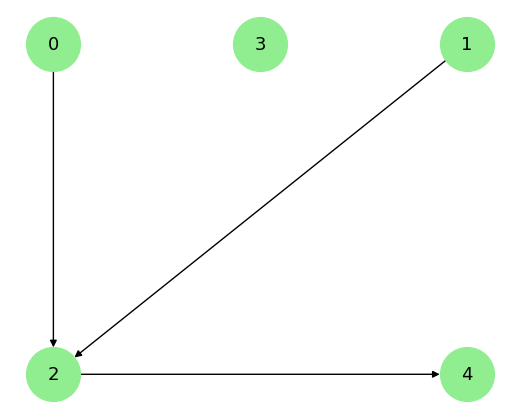

In [5]:



# https://stackoverflow.com/questions/20133479/how-to-draw-directed-graphs-using-networkx-in-python
import networkx as nx

import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
G = nx.DiGraph()
nodes = {0: (1,1.5), 1: (2,1.5), 2: (1,1), 4: (2,1), 3: (1.5,1.5)}
G.add_nodes_from(nodes.keys())
G.add_edges_from([(0,2), (1,2), (2,4)])
#arcs = nx.draw_networkx_edges(G, pos=nx.spring_layout(G))

for n, p in nodes.items():
   G.nodes[n]['pos'] = p

nx.draw(G, pos=nodes, with_labels=True, font_size=13, node_size=1500, node_color='lightgreen')
ax = plt.gca()
#ax.set_title('Graph with prefixed structure for requriments dependencies')
#plt.savefig("images/G.svg")
plt.show()


Ancestral order: [3,0,1,2,4]

##### a) Sampling of first generation:

In the dependencies structure shown above, when sampling the first set of solutions, the requirement in each solution is selected given the following probabilites:

P(3) = 1/5

P(0) = 1/5

P(1) = 1/5

P(2) = 1 if requirement 0 or 1 has been selected in current solution; 1/5 otherwise.

P(4) = 1 if requirement 2 has been selected in current soluction; 1/5 otherwise.

Let us assume that we sample 6 individuals with the following result:

solutions = 
            
            [ [1 0 1 0 1]

              [0 0 0 0 1]

              [0 0 1 1 1]

              [0 0 0 0 0]

              [0 0 1 0 1]
              
              [1 1 0 1 1] 
              

            ]
            
An impossible sampled individual would be, for example: [0 1 0 0 1] because requirement 2 should be selected since requirement 1 is.
Thus, the dependencies graph structured is respected.

The whole population is evaluated, and the local NDS in current iteration set is identified. Let us assume this NDS:

nds_local = 

            [
 
            [0 0 0 0 1] 

            [0 0 0 0 0] 
                        
            [0 0 1 0 1] 

            [1 1 0 1 1] 
            ]

nds_global = nds_local

##### b) Learning
This step consists in updating the sampling probability of each requirement from the nds_local population. 

P(0) = 1/4   

P(1) = 1/4   

P(2) = P_nds_local(2|requirement_0=0 and requirement_1=0) = 1/3  

P(3) = 1/4

P(4) = P_nds_local(4|requirement_2=0) = 2/3

Thus, our probabilities vector is now:

probabilities =

            [0.25, 0.25, 0.33, 0.25, 0.66]
 

 #### Sidenote about learning

we could have special cases in which a requirement is never selected. For instance, let us imagine this local NDS:

nds_local = 

            [
             [1 0 1 1 1]

             [0 0 1 0 1]

             [0 0 0 1 1]
            ]

P(1) = 0, so sampling of new individuals would not select requirement 1 anymore. In this case, we keep P(1) as its previous stored probability.
Another possible alleaviations to this cases could be learning P(1) from the global NDS, or using some smooth.


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2029190870.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/Gprobs.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2029190870.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/Gprobs.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2029190870.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/Gprobs.svg")


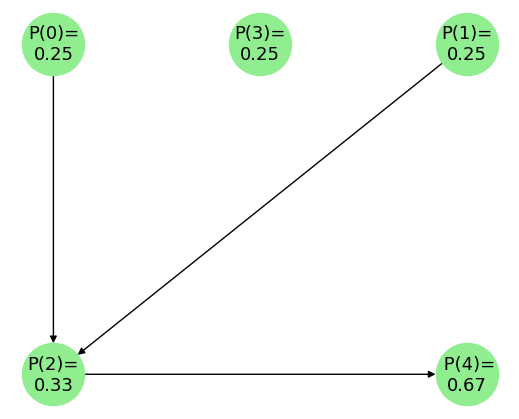

In [6]:
from matplotlib.pyplot import text
plt.figure(figsize=(5,4))
G = nx.DiGraph()
nodes = {0: (1,1.5), 1: (2,1.5), 2: (1,1), 4: (2,1), 3: (1.5,1.5)}
G.add_nodes_from(nodes.keys())
G.add_edges_from([(0,2), (1,2), (2,4)])
#arcs = nx.draw_networkx_edges(G, pos=nx.spring_layout(G))
pos = nx.spring_layout(G)

for n, p in nodes.items():
   G.nodes[n]['pos'] = p

labeldict = {0: "P(0)=\n0.25", 1: "P(1)=\n0.25",2: "P(2)=\n0.33",3: "P(3)=\n0.25",4: " P(4)=\n0.67"}


nx.draw(G, pos=nodes, labels=labeldict, with_labels=True, font_size=13, node_size=2000, node_color='lightgreen')
#for node, _ in pos.items(): # customize text size
   #text(nodes[node][0], nodes[node][1], labeldict[node], fontsize=15, ha='center', va='center')
ax = plt.gca()
#ax.set_title('Marginal/conditioned probability for each requirement')

#plt.savefig("images/Gprobs.svg")
plt.show()


##### c) Sampling

Each new individual is sampled given the Ancestral order: [3,0,1,2,4], and using the following probabilities:

P(3) = 0.5

P(0) = 0.25

P(1) = 0.25

P(2) = 1 if requirement 0 or 1 is selected. 0.5 otherwise.

P(4) = 1 if requirement 2 is selected. 0.66 otherwise.

Let us assume that we sample 6 individuals with the following result:

new_solutions = 
            
            [ [0 0 0 1 1]

              [0 0 1 1 1]

              [1 1 1 0 1]

              [0 0 1 1 1]

              [0 0 0 1 0]
              
              [0 0 0 0 1]
            ]
 
 We evaluate the solutions to:
 - update the global NDS given the new_solution population 
 - set local NDS to the nds found in new_soluction population 


Repeat Learning+Sampling until stop criterion.

***Example of transforming combination interactions***

/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3100659018.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/combination1.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3100659018.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/combination1.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3100659018.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/combination1.svg")


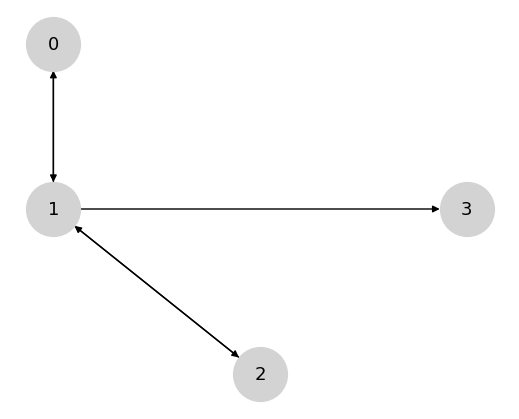

/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3100659018.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/combination2.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3100659018.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/combination2.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3100659018.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/combination2.svg")


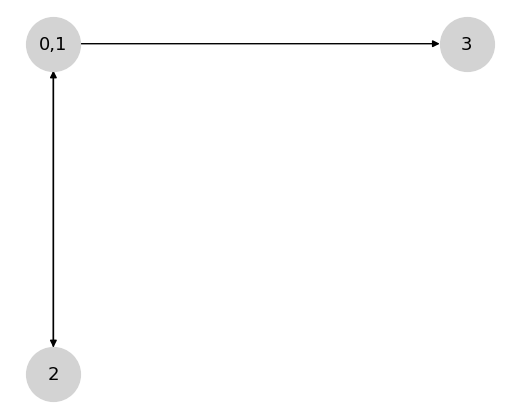

/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3100659018.py:50: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/combination3.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3100659018.py:50: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/combination3.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3100659018.py:50: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/combination3.svg")


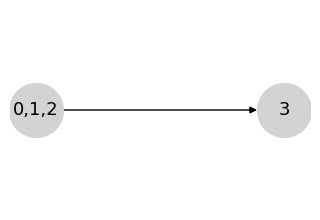

In [7]:
import networkx as nx

import matplotlib.pyplot as plt

#first
plt.figure(figsize=(5,4))
G = nx.DiGraph()
nodes = {0: (1,1.5), 1: (1,1), 2: (1.5,0.5), 3: (2,1)}
G.add_nodes_from(nodes.keys())
G.add_edges_from([(0,1),(1,0), (1,2),(2,1), (1,3)])
#arcs = nx.draw_networkx_edges(G, pos=nx.spring_layout(G))

for n, p in nodes.items():
   G.nodes[n]['pos'] = p

nx.draw(G, pos=nodes, with_labels=True, font_size=13, node_size=1500, node_color='lightgrey')
ax = plt.gca()
#ax.set_title('Graph with prefixed structure for requriments dependencies')
plt.savefig("images/combination1.svg")
plt.show()


#second
plt.figure(figsize=(5,4))
G = nx.DiGraph()
nodes = {"0,1": (1,1.5), 2: (1,1),  3: (2,1.5)}
G.add_nodes_from(nodes.keys())
G.add_edges_from([("0,1",2),(2,"0,1"), ("0,1",3)])

for n, p in nodes.items():
   G.nodes[n]['pos'] = p
nx.draw(G, pos=nodes, with_labels=True, font_size=13, node_size=1500, node_color='lightgrey')
ax = plt.gca()
plt.savefig("images/combination2.svg")
plt.show()


#third
#second
plt.figure(figsize=(3,2))
G = nx.DiGraph()
nodes = {"0,1,2": (1,1), 3: (1.5,1)}
G.add_nodes_from(nodes.keys())
G.add_edges_from([("0,1,2",3)])

for n, p in nodes.items():
   G.nodes[n]['pos'] = p
nx.draw(G, pos=nodes, with_labels=True, font_size=13, node_size=1500, node_color='lightgrey')
ax = plt.gca()
#plt.savefig("images/combination3.svg")
plt.show()



In [8]:
import math

def getdf_with_params_and_metrics(files, keep_parameters):

    parameters_dictios_list = []
    metrics_dictios_list = []
    
    
    for file in files:
        with open(file, 'r') as f:
            dictio = json.load(f)
            parameters_dictios_list.append(dictio['parameters'])
            metrics_dictios_list.append(dictio['metrics'])
        
            

    parameters_df= pd.DataFrame(parameters_dictios_list)
    parameters_df = parameters_df[['dataset'] + keep_parameters]

    metrics_df = pd.DataFrame(metrics_dictios_list)
    
    metrics_df = metrics_df[keep_metrics]
    #lists = metrics_df['gdplus']
    #for l in lists:
     #   for x in l:
      #      if isinstance(x, str): print(x, l)

    
    for column in keep_metrics: #we have several runs for each metric (list of values in each cell), so compute mean
        #metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist())
        metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist()).mean(axis=1)
    #display(metrics_df)
    combined_df=parameters_df.join(metrics_df)
    combined_df['file']=files

    return combined_df

In [9]:
import pandas as pd
import re

# Counts the number of wins (HV by default) for each configuration in data_df of the given hyperparameters.
# Each win is computed from results for a dataset
# returns:
#    dictionary with the, most frequently, best configuration. if ties, then first occurrence is returned
#    dictionary with the count of configuration which were the best at leats once
#    number of datasets    
# 
def get_best_configuration(data_df, hyperparameters, metric: str = 'HV') -> dict:
    
    dataset_groups = data_df.groupby(['dataset'])
    best_configs_counts = {}


    for group in dataset_groups: # find best hyperparameters config
        #print(group)
        group_df = pd.DataFrame(group[1])
        max_index = group_df[metric].idxmax()
        best_config = (group[1][hyperparameters]).loc[max_index]
        dataset_name = (group[1]['dataset']).loc[max_index] #any row
        file_name = (group[1]['file']).loc[max_index] 
        
        key = best_config.to_string()
        besthv = round(group_df[metric].loc[max_index], 4)
        if key in best_configs_counts.keys():
            (count, list_datasets, list_hv, list_files) = best_configs_counts[key]
            list_datasets.extend([dataset_name])
            list_hv.extend([besthv])
            list_files.extend([file_name])
           
            best_configs_counts[key]= (count + 1, list_datasets, list_hv, list_files)
        else:
            best_configs_counts[key] = (1, [dataset_name], [besthv], [file_name])

           
    
    #print(best_configs_counts)
   # print(len(best_configs_counts))
    #print(best_configs_counts)
    v = list(best_configs_counts.values())
    k = list(best_configs_counts.keys())
    best_config = k[v.index(max(v))]

    #convert string of best config to dictionary 
    best_config = re.sub(' +',' ',best_config)
    best_config = best_config.replace(' ',':')
    best_config = best_config.replace('\n',',')
    best = dict((x.strip(), y.strip())
             for x, y in (element.split(':') 
             for element in best_config.split(',')))
    return best, best_configs_counts, len(dataset_groups)
    
        

In [10]:
# convert dictionary counts of each best configuration to dataframe
def dictionary_keystring_to_dataframe(keep_parameters, best_counts):
    table_df = pd.DataFrame(columns=keep_parameters+['datasets'])
    for k in best_counts.keys():
        #print(f"{k} \n\t\t---> was the best config in: {best_counts[k]} datasets")
        row_dict = dict()
        for col in keep_parameters:
            start=k.index(col+' ')
            try: 
                end=k.index("\n", start)
            except: end = len(k)
            line = k[start:end]
            key = line[0:line.index(' ')]
            value = line[line.rfind(' ')+1:len(line)]
            row_dict[key]=value
        (counts, datasets_names, HVs, file_example) = best_counts[k]
        row_dict['datasets'] = datasets_names
        row_dict['HV'] = HVs
        row_dict['wins'] = int(counts)
        row_dict['file'] = file_example
        table_df = table_df.append(row_dict, ignore_index=True)
    return table_df

In [11]:
def print_hyperparams_values(df, hyperparmeters, algorithm):
    print(f"These are the different values used to set hyperparameters in {algorithm}, for each dataset:")
    mult = 1
    for hp in hyperparmeters:
        values = df[hp].unique()
        mult = mult * len(values)
        print(f"{hp}: {values}")
    print(f"In total, {mult} configuration per dataset.")

## 3. Search of the best hyperparameters configuration for each algorithm.

#### 3.1 Best configuration for: FEDA

In [12]:
keep_parameters = ['population_length', 'max_generations', 'selection_scheme'] 

# files_container = '../output/filest_list_feda'

algorithm =  'feda'


files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

print(datasets_names)

df_feda = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_feda = df_feda[df_feda.dataset.isin(datasets_names)]
#print(df_feda)
print_hyperparams_values(df_feda, keep_parameters, "FEDA")
#display(df_feda)

best_config_feda, best_counts, ndatasets= get_best_configuration(data_df=df_feda, hyperparameters=keep_parameters, metric='HV')
best_for_feda_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")
display(best_for_feda_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for FEDA is:")
for param in best_config_feda:
    print(f"{param}:{best_config_feda[param]}")

pd.set_option('display.float_format', '{:.3f}'.format)
print(best_for_feda_df.drop(['file','selection_scheme'], axis=1, inplace=False).to_latex(index=False))


['p1', 'p2', 'a1', 'a2', 'a3', 'a4', 'c1', 'c2', 'c3', 'c4', 'd1', 'd2', 'd3', 'd4']
These are the different values used to set hyperparameters in FEDA, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_scheme: ['nds']
In total, 25 configuration per dataset.

Counts of best configurations found in 14 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/243082509.py:17: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group in dataset_groups: # find best hyperparameters config
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row_dict, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row_dict, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: Fu

,population_length,max_generations,selection_scheme,datasets,HV,wins
0,1000,300,nds,"[a1, a2, c2, c3, d2, p1]","[0.8728, 0.9435, 0.932, 0.9061, 0.808, 0.8949]",6.000
1,1000,50,nds,"[a3, a4, d4]","[0.8244, 0.8047, 0.781]",3.000
2,1000,400,nds,"[c1, c4]","[0.8999, 0.8521]",2.000
3,1000,200,nds,"[d1, p2]","[0.8099, 0.7955]",2.000
4,1000,100,nds,[d3],[0.8011],1.000



Best hyperparameter configuration for FEDA is:
population_length:1000
max_generations:300
selection_scheme:nds
\begin{tabular}{llllr}
\toprule
population\_length & max\_generations &                 datasets &                                             HV &  wins \\
\midrule
             1000 &             300 & [a1, a2, c2, c3, d2, p1] & [0.8728, 0.9435, 0.932, 0.9061, 0.808, 0.8949] & 6.000 \\
             1000 &              50 &             [a3, a4, d4] &                        [0.8244, 0.8047, 0.781] & 3.000 \\
             1000 &             400 &                 [c1, c4] &                               [0.8999, 0.8521] & 2.000 \\
             1000 &             200 &                 [d1, p2] &                               [0.8099, 0.7955] & 2.000 \\
             1000 &             100 &                     [d3] &                                       [0.8011] & 1.000 \\
\bottomrule
\end{tabular}



/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3495320982.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(best_for_feda_df.drop(['file','selection_scheme'], axis=1, inplace=False).to_latex(index=False))


#### 3.2 Best configuration for: GRASP

It takes too long. In the few datasets in which results are available, GRASP's HV is better than all algorithms. However, in one week experiments did not finish for datasets with a large number of PBIs.

In [13]:
#filest_list_GRASP contains all output files from the GRASP algorithm. Goal is to find the best hyperparameters configuration.
# 
if('grasp' in files_container):

    keep_parameters = ['solutions_per_iteration', 'iterations', 'init_type', 'local_search_type', 'path_relinking_mode']
    

    files = []
    with open(files_container, 'r') as f:
        for line in f:
            files.append('../'+str(line.replace('\n','')))

    df_grasp = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    df_grasp = df_grasp[df_grasp.dataset.isin(datasets_names)]
    print_hyperparams_values(df_grasp, keep_parameters, "GRASP")

    #display(df_grasp)

    best_config_grasp, best_counts, ndatasets= get_best_configuration(data_df=df_grasp, hyperparameters=keep_parameters, metric='HV')
    best_for_grasp_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)

    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")


    display(best_for_grasp_df.drop(['file'], axis=1, inplace=False))


    print(f"\nBest hyperparameter configuration for GRASP is:")
    for param in best_config_grasp:
        print(f"{param}:{best_config_grasp[param]}")




#### 3.3 Best configuration for: GeneticNDS


In [14]:
# files_container contains all output files from the geneticNDS algorithm. Goal is to find the best hyperparameters configuration.
algorithm =  'geneticnds'
keep_parameters = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement']
#files_container = '../output/filest_list_geneticnds'



files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_genetic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_genetic = df_genetic[df_genetic.dataset.isin(datasets_names)]
print_hyperparams_values(df_genetic, keep_parameters, "GeneticNDS")

#display(df_genetic)
best_config_geneticNDS, best_counts, ndatasets= get_best_configuration(data_df=df_genetic, hyperparameters=keep_parameters, metric='HV')

best_for_geneticnds_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")

display(best_for_geneticnds_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for GeneticNDS is:")
for param in best_config_geneticNDS:
    print(f"{param}:{best_config_geneticNDS[param]}")


print(best_for_geneticnds_df.drop(['file','selection_candidates','crossover_prob', 'mutation', 'replacement'], axis=1, inplace=False).to_latex(index=False))
        



These are the different values used to set hyperparameters in GeneticNDS, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_candidates: [2]
crossover_prob: [0.8]
mutation_prob: [0.1]
mutation: ['flip1bit']
replacement: ['elitismnds']
In total, 25 configuration per dataset.

Counts of best configurations found in 14 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/243082509.py:17: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group in dataset_groups: # find best hyperparameters config
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row_dict, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row_dict, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: Fu

,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,datasets,HV,wins
0,1000,200,2,0.800,0.100,flip1bit,elitismnds,"[a1, d3]","[0.8135, 0.6643]",2.000
1,1000,300,2,0.800,0.100,flip1bit,elitismnds,"[a2, a3, a4, c2, c4, d2, d4, p2]","[0.8837, 0.6963, 0.6915, 0.8269, 0.7201, 0.691...",8.000
2,1000,50,2,0.800,0.100,flip1bit,elitismnds,"[c1, p1]","[0.8479, 0.8925]",2.000
3,1000,400,2,0.800,0.100,flip1bit,elitismnds,"[c3, d1]","[0.7801, 0.7027]",2.000



Best hyperparameter configuration for GeneticNDS is:
population_length:1000
max_generations:300
selection_candidates:2
crossover_prob:0.800
mutation_prob:0.100
mutation:flip1bit
replacement:elitismnds
\begin{tabular}{lllllr}
\toprule
population\_length & max\_generations & mutation\_prob &                         datasets &                                                 HV &  wins \\
\midrule
             1000 &             200 &         0.100 &                         [a1, d3] &                                   [0.8135, 0.6643] & 2.000 \\
             1000 &             300 &         0.100 & [a2, a3, a4, c2, c4, d2, d4, p2] & [0.8837, 0.6963, 0.6915, 0.8269, 0.7201, 0.6911... & 8.000 \\
             1000 &              50 &         0.100 &                         [c1, p1] &                                   [0.8479, 0.8925] & 2.000 \\
             1000 &             400 &         0.100 &                         [c3, d1] &                                   [0.7801, 0.7027] & 2.000 \

/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3509980195.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(best_for_geneticnds_df.drop(['file','selection_candidates','crossover_prob', 'mutation', 'replacement'], axis=1, inplace=False).to_latex(index=False))


#### 3.4 Best configuration for: random


In [15]:
# Liles_container' contains all output files from the UMDA algorithm. Goal is to find the best hyperparameters configuration.
algorithm = 'random'
keep_parameters = ['population_length', 'max_generations']

#files_container = '../output/filest_list_umda'



files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_random = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_random = df_random[df_random.dataset.isin(datasets_names)]
print_hyperparams_values(df_random, keep_parameters, "RANDOM")
#display(df_umda)
best_config_random, best_counts, ndatasets= get_best_configuration(data_df=df_random, hyperparameters=keep_parameters, metric='HV')
best_for_random_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")


display(best_for_random_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for RANDOM is:")
for param in best_config_random:
    print(f"{param}:{best_config_random[param]}")


print(best_for_random_df.drop(['file'], axis=1, inplace=False).to_latex(index=False))

These are the different values used to set hyperparameters in RANDOM, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
In total, 25 configuration per dataset.

Counts of best configurations found in 14 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/243082509.py:17: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group in dataset_groups: # find best hyperparameters config
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row_dict, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row_dict, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: Fu

,population_length,max_generations,datasets,HV,wins
0,700,300,[a1],[0.8342],1.000
1,1000,400,"[a2, a3, a4, c1, c3, c4, d1, d2, d3, d4, p2]","[0.9007, 0.775, 0.7661, 0.8808, 0.8238, 0.7874...",11.000
2,1000,300,[c2],[0.861],1.000
3,700,50,[p1],[0.8537],1.000



Best hyperparameter configuration for RANDOM is:
population_length:1000
max_generations:400
\begin{tabular}{llllr}
\toprule
population\_length & max\_generations &                                     datasets &                                                 HV &   wins \\
\midrule
              700 &             300 &                                         [a1] &                                           [0.8342] &  1.000 \\
             1000 &             400 & [a2, a3, a4, c1, c3, c4, d1, d2, d3, d4, p2] & [0.9007, 0.775, 0.7661, 0.8808, 0.8238, 0.7874,... & 11.000 \\
             1000 &             300 &                                         [c2] &                                            [0.861] &  1.000 \\
              700 &              50 &                                         [p1] &                                           [0.8537] &  1.000 \\
\bottomrule
\end{tabular}



/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2489933835.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(best_for_random_df.drop(['file'], axis=1, inplace=False).to_latex(index=False))


#### 3.4 Best configuration for: UMDA



In [16]:
# Liles_container' contains all output files from the UMDA algorithm. Goal is to find the best hyperparameters configuration.
algorithm = 'umda'
keep_parameters = ['population_length', 'max_generations', 'selection_scheme', 'replacement_scheme']

#files_container = '../output/filest_list_umda'



files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_umda = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_umda = df_umda[df_umda.dataset.isin(datasets_names)]
print_hyperparams_values(df_umda, keep_parameters, "UMDA")
#display(df_umda)
best_config_umda, best_counts, ndatasets= get_best_configuration(data_df=df_umda, hyperparameters=keep_parameters, metric='HV')
best_for_umda_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")


display(best_for_umda_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for UMDA is:")
for param in best_config_umda:
    print(f"{param}:{best_config_umda[param]}")


print(best_for_umda_df.drop(['file', 'replacement_scheme','selection_scheme'], axis=1, inplace=False).to_latex(index=False))

These are the different values used to set hyperparameters in UMDA, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_scheme: ['nds']
replacement_scheme: ['elitism']
In total, 25 configuration per dataset.

Counts of best configurations found in 14 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/243082509.py:17: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group in dataset_groups: # find best hyperparameters config
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row_dict, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row_dict, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: Fu

,population_length,max_generations,selection_scheme,replacement_scheme,datasets,HV,wins
0,1000,50,nds,elitism,"[a1, a3, c3, c4, d1]","[0.8639, 0.8031, 0.8779, 0.8204, 0.7945]",5.000
1,1000,400,nds,elitism,"[a2, d4, p1]","[0.9303, 0.7516, 0.8998]",3.000
2,1000,300,nds,elitism,"[a4, c1]","[0.7942, 0.8819]",2.000
3,1000,200,nds,elitism,"[c2, d2]","[0.8631, 0.802]",2.000
4,1000,100,nds,elitism,"[d3, p2]","[0.7648, 0.781]",2.000



Best hyperparameter configuration for UMDA is:
population_length:1000
max_generations:50
selection_scheme:nds
replacement_scheme:elitism
\begin{tabular}{llllr}
\toprule
population\_length & max\_generations &             datasets &                                       HV &  wins \\
\midrule
             1000 &              50 & [a1, a3, c3, c4, d1] & [0.8639, 0.8031, 0.8779, 0.8204, 0.7945] & 5.000 \\
             1000 &             400 &         [a2, d4, p1] &                 [0.9303, 0.7516, 0.8998] & 3.000 \\
             1000 &             300 &             [a4, c1] &                         [0.7942, 0.8819] & 2.000 \\
             1000 &             200 &             [c2, d2] &                          [0.8631, 0.802] & 2.000 \\
             1000 &             100 &             [d3, p2] &                          [0.7648, 0.781] & 2.000 \\
\bottomrule
\end{tabular}



/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/1797571070.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(best_for_umda_df.drop(['file', 'replacement_scheme','selection_scheme'], axis=1, inplace=False).to_latex(index=False))


#### 3.5 Best configuration for: PBIL


In [17]:
algorithm = 'pbil'
keep_parameters = ['population_length', 'max_generations','max_evaluations', 'learning_rate', 'mutation_prob','mutation_shift']

#files_container = '../output/filest_list_pbil'


files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_pbil = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_pbil = df_pbil[df_pbil.dataset.isin(datasets_names)]
print_hyperparams_values(df_pbil, keep_parameters, "PBIL")
#display(df_pbil)
best_config_pbil, best_counts, ndatasets= get_best_configuration(data_df=df_pbil, hyperparameters=keep_parameters, metric='HV')
best_for_pbil_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")
display(best_for_pbil_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for PBIL is:")
for param in best_config_pbil:
    print(f"{param}:{best_config_pbil[param]}")

print(best_for_pbil_df.drop(['file', 'learning_rate','mutation_prob', 'max_evaluations',
'mutation_shift'], axis=1, inplace=False).to_latex(index=False))







These are the different values used to set hyperparameters in PBIL, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
max_evaluations: [0]
learning_rate: [0.1]
mutation_prob: [0.1]
mutation_shift: [0.1]
In total, 25 configuration per dataset.

Counts of best configurations found in 14 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/243082509.py:17: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group in dataset_groups: # find best hyperparameters config
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row_dict, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row_dict, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: Fu

,population_length,max_generations,max_evaluations,learning_rate,mutation_prob,mutation_shift,datasets,HV,wins
0,1000.000,400.000,0.000,0.100,0.100,0.100,"[a1, c1, c2, c3, c4, d1, d2, d3, d4, p2]","[0.8968, 0.903, 0.9421, 0.7414, 0.7336, 0.7197...",10.000
1,700.000,400.000,0.000,0.100,0.100,0.100,"[a2, a3, a4]","[0.9736, 0.6568, 0.6583]",3.000
2,100.000,400.000,0.000,0.100,0.100,0.100,[p1],[0.9078],1.000



Best hyperparameter configuration for PBIL is:
population_length:1000.000
max_generations:400.000
max_evaluations:0.000
learning_rate:0.100
mutation_prob:0.100
mutation_shift:0.100
\begin{tabular}{llllr}
\toprule
population\_length & max\_generations &                                 datasets &                                                 HV &   wins \\
\midrule
         1000.000 &         400.000 & [a1, c1, c2, c3, c4, d1, d2, d3, d4, p2] & [0.8968, 0.903, 0.9421, 0.7414, 0.7336, 0.7197,... & 10.000 \\
          700.000 &         400.000 &                             [a2, a3, a4] &                           [0.9736, 0.6568, 0.6583] &  3.000 \\
          100.000 &         400.000 &                                     [p1] &                                           [0.9078] &  1.000 \\
\bottomrule
\end{tabular}



/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3143041767.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  'mutation_shift'], axis=1, inplace=False).to_latex(index=False))


#### 3.6 Best configuracion for: MIMIC


In [18]:
if('mimic' in files_container):

    algorithm = 'mimic'
    keep_parameters = ['population_length', 'max_generations','max_evaluations', 'selection_scheme', 'selected_individuals']




    files = []
    with open(files_container, 'r') as f:
        for line in f:
            if algorithm in line:
                files.append('../'+str(line.replace('\n','')))

    df_mimic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    df_mimic = df_mimic[df_mimic.dataset.isin(datasets_names)]
    print_hyperparams_values(df_mimic, keep_parameters, "MIMIC")
    #display(df_mimic)
    best_config_mimic, best_counts, ndatasets= get_best_configuration(data_df=df_mimic, hyperparameters=keep_parameters, metric='HV')
    best_for_mimic_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")
    display(best_for_mimic_df.drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for MIMIC is:")
    for param in best_config_mimic:
        print(f"{param}:{best_config_mimic[param]}")



These are the different values used to set hyperparameters in MIMIC, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
max_evaluations: [0]
selection_scheme: ['nds']
selected_individuals: [50]
In total, 25 configuration per dataset.

Counts of best configurations found in 14 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/243082509.py:17: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group in dataset_groups: # find best hyperparameters config
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row_dict, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row_dict, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2888886389.py:21: Fu

,population_length,max_generations,max_evaluations,selection_scheme,selected_individuals,datasets,HV,wins
0,1000,50,0,nds,50,[a1],[0.854],1.000
1,1000,100,0,nds,50,[a2],[0.9141],1.000
2,1000,300,0,nds,50,"[a3, c2, d3]","[0.8158, 0.8634, 0.7574]",3.000
3,1000,400,0,nds,50,"[a4, c1, c3, c4, d1, d4, p2]","[0.8051, 0.8885, 0.8841, 0.8165, 0.8026, 0.75,...",7.000
4,1000,200,0,nds,50,[d2],[0.7962],1.000
5,200,200,0,nds,50,[p1],[0.835],1.000



Best hyperparameter configuration for MIMIC is:
population_length:1000
max_generations:400
max_evaluations:0
selection_scheme:nds
selected_individuals:50


All algorithms find their best results when using a Population Size = 1000, the maximum value among the 5 given for this hyperparameter.

Respect to the number of generations, all algorithms but UMDA are slow to converge, needing the maximum (400)  almost the maximum (300 in FEDA) value among the possible values. UMDA seems to converge really soon, since in 6 out of 17 datasets it finds its best results with just 50 generations, in both agile and classic projects.


## 4. Pareto plots for each dataset, setting each algorithm with its best configuration found (wins among all datasets).
Given the most frequently best configuration (over all datasets), we plot the pareto for each dataset given that configuration. That is, the configuration for a given algorithm is the same acrooss all datasets, concretely the one which performed the best more times (more wins).

We show a plot for each dataset. In each plot, for each algorithm, we show the pareto front found in all the executions (commonly 30). Since the solutions subset size is commonly 10, thus for each algorithm we plot 300 points. Since each algorithm has 30 paretos, please note that such paretos are not non-dominated among them, which can be seen in the  shapes they create.

#### 4.1 Metrics

We show the average results over 30 executions for each algorithm. Each execution produces a NDS, from wich we keep the subset of 10 solutions which maximize HV, as suggested in 'Difficulties in Fair Performance Comparison of Multi-Objective Evolutionary Algorithms'. Such a subset is constructed by following an incremental forward greedy search. 

Metrics shown are: 4 Quality Indiciators (HV, gd+, UNFR, spread), time and cardinality of the global NDS found by the algorithm during execution.

- HV (Hypervolume): this is the most widely used metric to assess paretos solutions for multi-objective problems and, concretly, in SBSE. It summarizes the four aspects of a solution set (convergence, spread, uniformity and cardinality); that is, this metric can be used as a compliance metric representing how good a Pareto front is. HV tends to be greater as knee points in the pareto are neareer the optimal point (0,0), thus it is preferable when Decision Makers prefer balanced solutions. In order to compute it, a reference point is needed, and this should be the same for all algorithms under comparison. Following the results and suggestions in ("How to evaluate solutions in pareto-based search-bases software engin."), we set the following reference point in our bi-objective problem:
                            $ref_x = nadir_x + range_x/10$ 
                            $ref_y = nadir_y + range_y/10$
The nadir point is the worst point found by algorithms during search. Since we normalize both cost and satisfaction, our worst point is 1 for both metrics (satisfaction is plotted as $1-satisfaction$). Range is the difference between the best and worst point found. Best point is 0, so clearly the value of the reference point for both goals is $1 + (1-0)/10 = 1.1$. HV is pareto compliance, so $HV_a > HV_b$ means that, visually, the pareto front of algorithm $a$ dominates algorithm $b$. A great advantage of HV is that it does not need an ideal Pareto Reference, so its computation and fair comparison with other algorithm only needs a shared reference point which, thanks to goals normalization, is known a priori.

/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2397372761.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/ParetoFront.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2397372761.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/ParetoFront.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2397372761.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/ParetoFront.svg")
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core

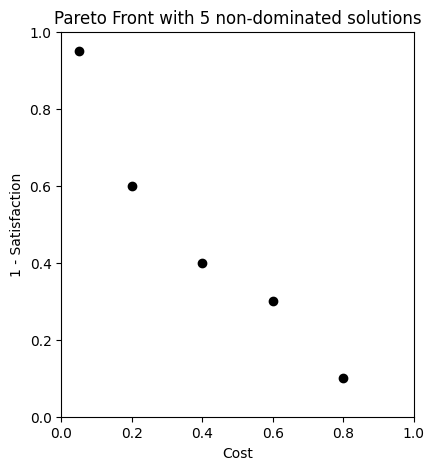

In [19]:
import matplotlib.pyplot as plt

ref = [1.1,1.1]
fig = plt.figure(figsize=(10,5)) #20,5 when plotting also ax2 with table
ax = fig.add_subplot(121)
ax.set_xlabel('Cost')
ax.set_ylabel('1 - Satisfaction')
ax.set_title("Pareto Front with 5 non-dominated solutions")
plt.xlim([0,1])
plt.ylim([0,1])
#plt.scatter(x=1.1, y=1.1)
#ax.annotate("ref point", (0.9,1.1 ))
solutions_x = [0.05, 0.2, 0.4, 0.6, 0.8]
solutions_y = [1-0.05,1- 0.4,1- 0.6,1- 0.7,1- 0.9]
plt.scatter(solutions_x,solutions_y,c="black")
#plt.savefig("images/ParetoFront.svg")







/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3334564221.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/HV.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3334564221.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/HV.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3334564221.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/HV.svg")


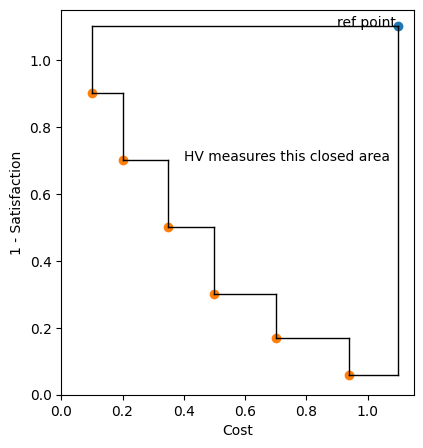

In [20]:
import matplotlib.pyplot as plt

ref = [1.1,1.1]
fig = plt.figure(figsize=(10,5)) #20,5 when plotting also ax2 with table
ax = fig.add_subplot(121)
ax.set_xlabel('Cost')
ax.set_ylabel('1 - Satisfaction')
#ax.set_title("HV with a random solution set and ref_point=(1.1,1.1)")
plt.xlim([0,1.15])
plt.ylim([0,1.15])
plt.scatter(x=1.1, y=1.1)
ax.annotate("ref point", (0.9,1.1 ))
solutions_x = [0.1, 0.2, 0.35, 0.5, 0.7, 0.94]
solutions_y = [1-0.1,1- 0.3,1- 0.5,1- 0.7,1- 0.83,1- 0.94]
plt.scatter(solutions_x,solutions_y)

plt.plot([0.1, 0.1], [0.9, 1.1], 'k-', lw=1)
plt.plot([0.1, 1.1], [1.1, 1.1], 'k-', lw=1)

plt.plot([0.94, 1.1], [0.06, 0.06], 'k-', lw=1)
plt.plot([1.1, 1.1], [0.06, 1.1], 'k-', lw=1)

for i in range(0,len(solutions_x)-1):
    x1 = solutions_x[i]
    y1 = solutions_y[i]
    x2 = solutions_x[i+1]
    y2 = solutions_y[i+1]

    plt.plot([x1, x2], [y1, y1], 'k-', lw=1)
    plt.plot([x2, x2], [y1, y2], 'k-', lw=1)

ax.annotate("HV measures this closed area", (0.4,0.7))

#plt.savefig("images/HV.svg")








- GD+: General Distance (GD) covers the convergence aspect of the quality of solution set, measuring the Euclidian distance of such solution set to the ideal Pareto Reference. For each solution, its GD is the minimum of the distances to each point in the PF. In order to become GD compliant with Pareto dominance, GD+ enhances GD by measuring distances between points using only the goal coordinates which are superior in the Pareto Reference than those from the solutions set being measured. This metric is to be minimized, and a key point is the computation of the Pareto Reference, which needs to be done after execution of search algorithms. In our experiments, Pareto Reference is constructed by finding the Non Dominated Solutions set among all solutions sets found by all algorithm, under all hyperparameters configurations explained in Section 2. 

- UNFR: Unique Non Dominated Front Ratio. It measures the ratio of solutio points in the PR which belong to the solution set of the evaluated algorithm. That is, it measures the contribution (from to 0 to 1) of an algorithm to the PR. Of curse, a point in the PR might be present in the solution sets of several algorithms. In our case, since the PR is constructed from such a large number of algorithms and configuration combinations, it presents a high cardinality of solutions. Furthermore, since each algorithm is evaluated using only using a selected subset of 10 points from its solution set, the UNFR value for each algorithm tends to be quite low, and the maximum possible is never 1, since the PR contais further more than 10 points. Anyway, greater UNFR values is desiderable. 




/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3541363281.py:84: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/GD_and_UNFR.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3541363281.py:84: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/GD_and_UNFR.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/3541363281.py:84: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/GD_and_UNFR.svg")


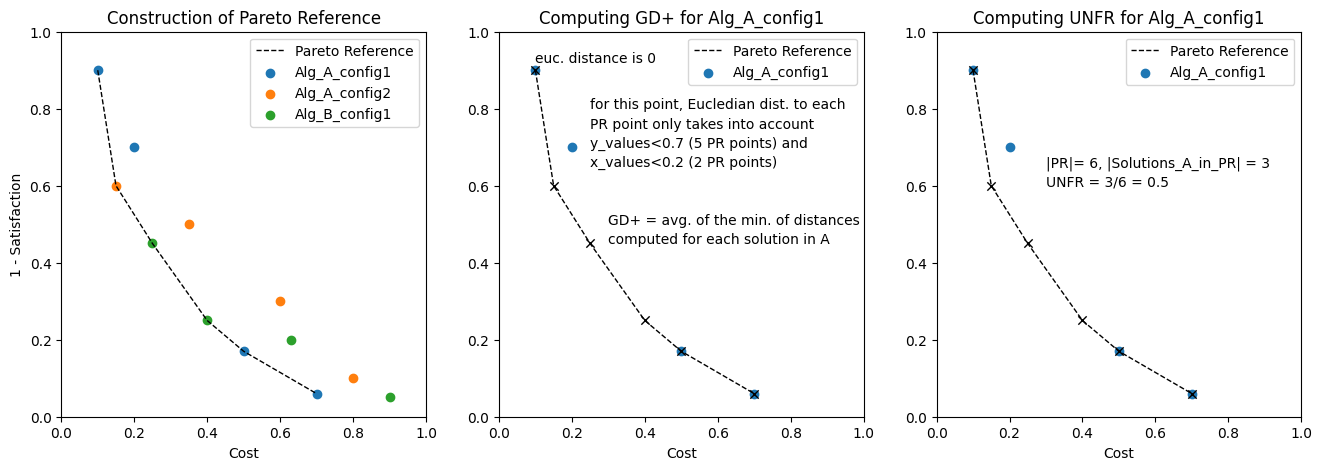

In [21]:

################# Pareto reference example ###################

fig = plt.figure(figsize=(16,5)) 
ax = fig.add_subplot(1,3,1)
ax.grid(False)
ax.set_xlabel('Cost')
ax.set_ylabel('1 - Satisfaction')
ax.set_title("Construction of Pareto Reference")
plt.xlim([0,1])
plt.ylim([0,1])

algA1_x = [0.1, 0.2, 0.5, 0.7]
algA1_y = [1-0.1,1- 0.3,1- 0.83,1- 0.94]

algA2_x = [0.15, 0.35, 0.6, 0.8]
algA2_y = [0.6, 0.5, 0.3, 0.1]

algB_x = [0.25, 0.4, 0.63, 0.9]
algB_y = [0.45, 0.25, 0.2, 0.05]

pr_x = [0.1,0.15,0.25,0.4,0.5,0.7]
pr_y = [0.9,0.6,0.45,0.25,0.17,0.06]

plt.scatter(algA1_x,algA1_y)
plt.scatter(algA2_x,algA2_y)
plt.scatter(algB_x,algB_y)
plt.plot(pr_x, pr_y, color='black', linestyle='--',linewidth=1)
#plt.scatter(pr_x, pr_y, color='black', marker='x', linewidth=1)

ax.legend(['Pareto Reference','Alg_A_config1', 'Alg_A_config2', 'Alg_B_config1'])




################# GD+ example ###################
ax = fig.add_subplot(1,3,2)
ax.grid(False)
ax.set_xlabel('Cost')
ax.set_title("Computing GD+ for Alg_A_config1")

plt.xlim([0,1])
plt.ylim([0,1])

algA1_x = [0.1, 0.2, 0.5, 0.7]
algA1_y = [1-0.1,1- 0.3,1- 0.83,1- 0.94]


plt.scatter(algA1_x,algA1_y)
#plt.scatter(pr_x, pr_y, marker='.', color='red')
plt.plot(pr_x, pr_y, color='black', linestyle='--',linewidth=1)
plt.scatter(pr_x, pr_y, color='black', marker='x', linewidth=1)
ax.legend(['Pareto Reference', 'Alg_A_config1'])
ax.annotate("euc. distance is 0", (0.1,0.92 ))
ax.annotate("for this point, Eucledian dist. to each ", (0.25,0.8 ))
ax.annotate("PR point only takes into account ", (0.25,0.75 ))
ax.annotate("y_values<0.7 (5 PR points) and", (0.25,0.70 ))
ax.annotate("x_values<0.2 (2 PR points)", (0.25,0.65 ))
ax.annotate("GD+ = avg. of the min. of distances", (0.3,0.5 ))
ax.annotate("computed for each solution in A", (0.3,0.45 ))

################# UNFR example ###################
ax = fig.add_subplot(1,3,3)
ax.grid(False)
ax.set_xlabel('Cost')
ax.set_title("Computing UNFR for Alg_A_config1")
plt.xlim([0,1])
plt.ylim([0,1])

algA1_x = [0.1, 0.2, 0.5, 0.7]
algA1_y = [1-0.1,1- 0.3,1- 0.83,1- 0.94]





plt.scatter(algA1_x,algA1_y)
plt.plot(pr_x, pr_y, color='black', linestyle='--',linewidth=1)
plt.scatter(pr_x, pr_y, color='black', marker='x', linewidth=1)
ax.grid(False)
ax.legend(['Pareto Reference','Alg_A_config1'])
ax.annotate("|PR|= 6, |Solutions_A_in_PR| = 3", (0.3,0.65 ))
ax.annotate("UNFR = 3/6 = 0.5", (0.3,0.6 ))

#plt.savefig("images/GD_and_UNFR.svg")



#### 4.2 Results

Here we show one plot pero datasets, containing the result of all algorithms with their best configuration. As mentioned before, each algorithm is run 30 times; afeter each execution, we keep a subset of the NDS constructed. This subset contains the 10 solutions from NDS which maximize HV in a forward greedy search over the NDS. Thus, for each algorithm, we plot 10*30=300 points. This way, it is easy to identify the common pareto shape relative to the algorithm. After each plot, all metrics are tabbed to show the average over the 30 executions in the dataset.

It is worth to mention that half of the execution time in algorithms is due to updating NDS after each iteration. Thus, although after each execution we select a subset of 10 solutions in the final NDS, more time consuming algorithms are usually those which tend to develop a NDS with higher cardinality suring their search.


In [22]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files


In [23]:
def get_files_list_with_best_configuration_per_dataset(alg_name):
       

    if alg_name=='GRASP':
        df_with_bests = best_for_grasp_df
    if alg_name=='UMDA':
        df_with_bests = best_for_umda_df
    if alg_name=='PBIL':
        df_with_bests = best_for_pbil_df
    if alg_name=='geneticNDS':
        df_with_bests = best_for_geneticnds_df
    if alg_name=='MIMIC':
        df_with_bests = best_for_mimic_df
    if alg_name=='random':
        df_with_bests = best_for_random_df
    if alg_name=='feda':
        df_with_bests = best_for_feda_df

    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_names:
        try:
            best_conf_row = df_with_bests.loc[df_with_bests['datasets'].apply(lambda x: dataset in x)].iloc[0]
            position = best_conf_row['datasets'].index(dataset)
            file = best_conf_row.file[position]
            algorithm_files.extend([file])
        except: print(f"not best file yet for {dataset} for algorithm {alg_name}")
    
    return algorithm_files
    


p1


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Pareto Reference has 38 points
Maximum UNFR possible is 10/38=0.2632


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases lat

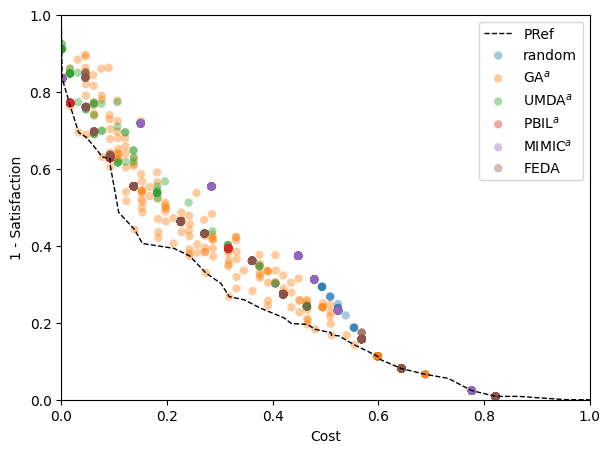

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.8402,0.1193,0.0560,0.6677,288.9696,38.2667
1,geneticNDS,0.8877,0.1000,0.0325,0.5996,524.9379,33.1000
2,UMDA,0.8978,0.0702,0.0356,0.6424,78.3496,35.7667
3,PBIL,0.9078,0.0789,0.0279,0.5323,418.9355,38.6667
4,MIMIC,0.8350,0.1053,0.0631,0.6501,691.8070,39.0000
5,feda,0.8949,0.0526,0.0390,0.6846,549.9175,35.3333


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
p2
Pareto Reference has 322 points
Maximum UNFR possible is 10/322=0.0311


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases lat

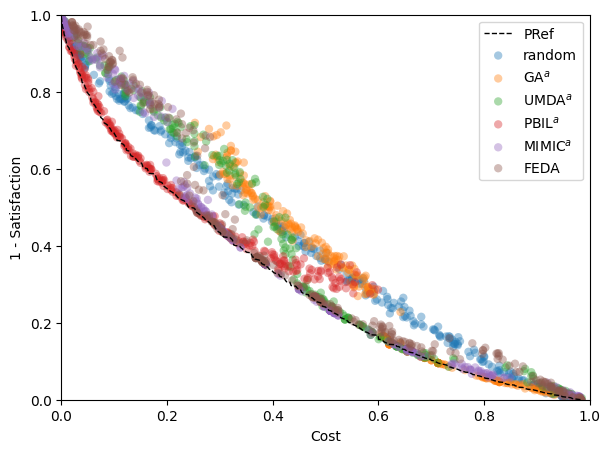

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.7615,0.0013,0.0568,0.5870,438.6427,124.8000
1,geneticNDS,0.6951,0.0057,0.0624,0.6520,1609.5523,97.4000
2,UMDA,0.7796,0.0027,0.0451,0.5587,355.7584,144.9667
3,PBIL,0.7323,0.0029,0.0153,0.5716,869.6195,101.5333
4,MIMIC,0.8166,0.0050,0.0183,0.5971,5204.7406,350.8333
5,feda,0.7926,0.0011,0.0319,0.6024,3157.3064,209.7000


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
a1


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPy

Pareto Reference has 143 points
Maximum UNFR possible is 10/143=0.0699


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases lat

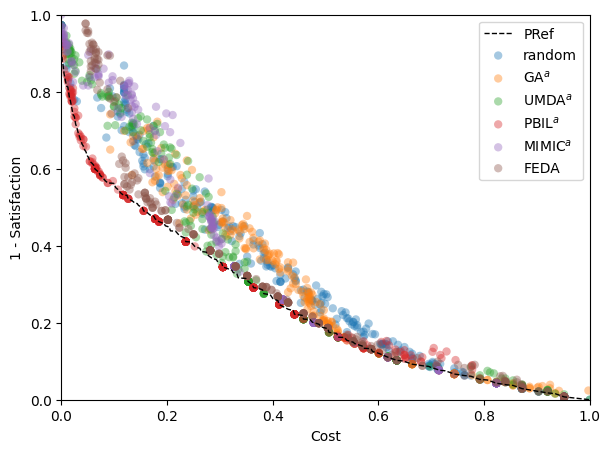

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.8334,0.0140,0.0480,0.6100,297.5637,68.6333
1,geneticNDS,0.8113,0.0240,0.0402,0.6532,826.1965,49.6333
2,UMDA,0.8639,0.0277,0.0299,0.5756,171.9596,67.0000
3,PBIL,0.8968,0.0487,0.0031,0.6078,645.5718,110.7667
4,MIMIC,0.8497,0.0305,0.0278,0.5611,1718.1189,131.6667
5,feda,0.8728,0.0119,0.0179,0.5812,1366.9178,94.9333


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
a2


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPy

Pareto Reference has 87 points
Maximum UNFR possible is 10/87=0.1149


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


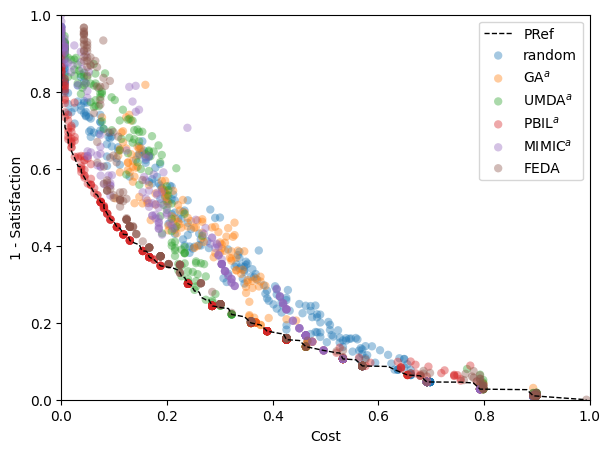

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.9007,0.0176,0.0499,0.5882,271.1401,57.9667
1,geneticNDS,0.8837,0.0579,0.0407,0.6726,618.2784,34.6333
2,UMDA,0.9290,0.0483,0.0279,0.5923,135.4683,47.1667
3,PBIL,0.9736,0.0785,0.0027,0.6097,486.3169,73.6000
4,MIMIC,0.9126,0.0444,0.0336,0.5965,1096.4249,79.1333
5,feda,0.9435,0.0142,0.0178,0.6313,671.2953,50.9667


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
a3


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPy

Pareto Reference has 301 points
Maximum UNFR possible is 10/301=0.0332


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases lat

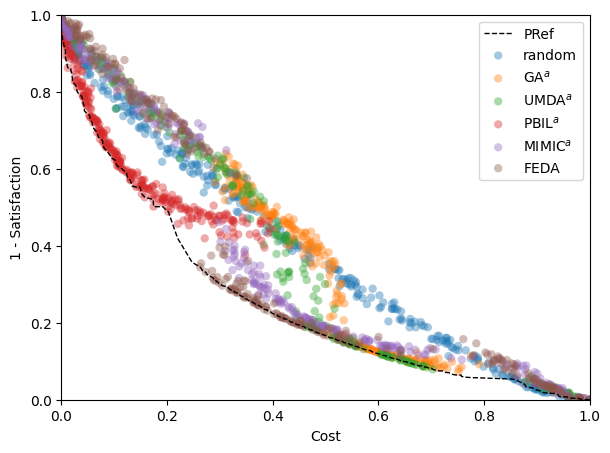

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.7750,0.0015,0.0842,0.5839,438.4771,120.5333
1,geneticNDS,0.6963,0.0001,0.0960,0.7452,1157.3341,70.2667
2,UMDA,0.8031,0.0030,0.0665,0.5809,336.8301,126.4667
3,PBIL,0.6558,0.0022,0.0275,0.5703,769.8283,62.8667
4,MIMIC,0.8144,0.0007,0.0502,0.6057,2010.3337,85.4333
5,feda,0.8238,0.0041,0.0460,0.5921,2168.7192,153.9000


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
a4


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PRO

Pareto Reference has 307 points
Maximum UNFR possible is 10/307=0.0326


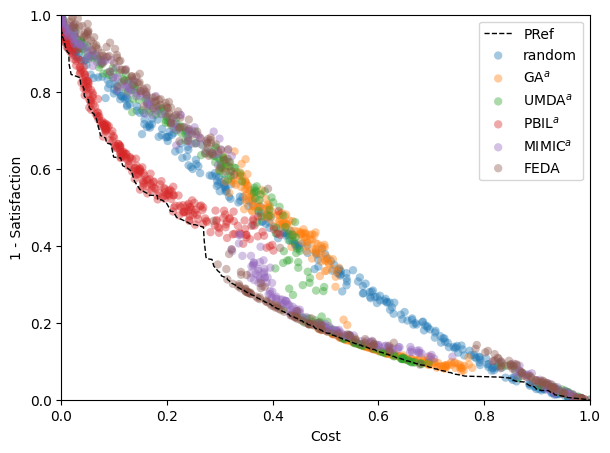

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.7661,0.0016,0.0800,0.6121,462.7827,133.9667
1,geneticNDS,0.6915,0.0023,0.0759,0.7387,1210.6799,78.6667
2,UMDA,0.7923,0.0022,0.0637,0.5875,355.7958,143.3667
3,PBIL,0.6576,0.0013,0.0237,0.5685,774.0930,64.6333
4,MIMIC,0.8051,0.0001,0.0477,0.5852,2098.3428,80.5000
5,feda,0.8022,0.0037,0.0497,0.6169,2563.3122,170.3000


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
c1
Pareto Reference has 156 points
Maximum UNFR possible is 10/156=0.0641


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canva

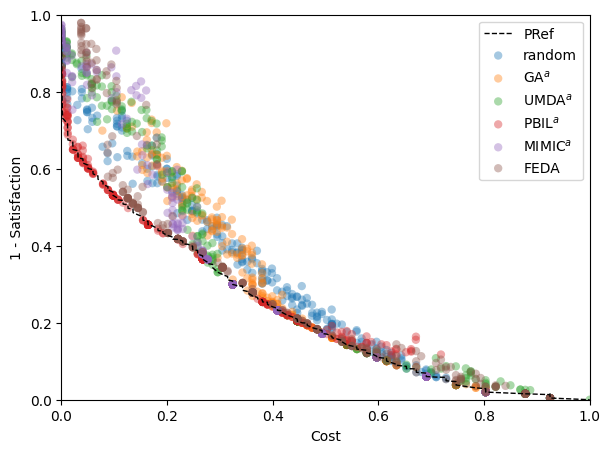

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.8808,0.0137,0.0372,0.6146,292.6890,68.2667
1,geneticNDS,0.8451,0.0314,0.0354,0.6501,1055.1650,62.0667
2,UMDA,0.8817,0.0271,0.0300,0.6068,215.5116,79.3000
3,PBIL,0.9030,0.0440,0.0036,0.6150,675.3096,105.7333
4,MIMIC,0.8885,0.0395,0.0158,0.6019,1876.2004,143.4667
5,feda,0.8967,0.0156,0.0170,0.6054,1142.1866,90.1667


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
c2
Pareto Reference has 162 points
Maximum UNFR possible is 10/162=0.0617


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canva

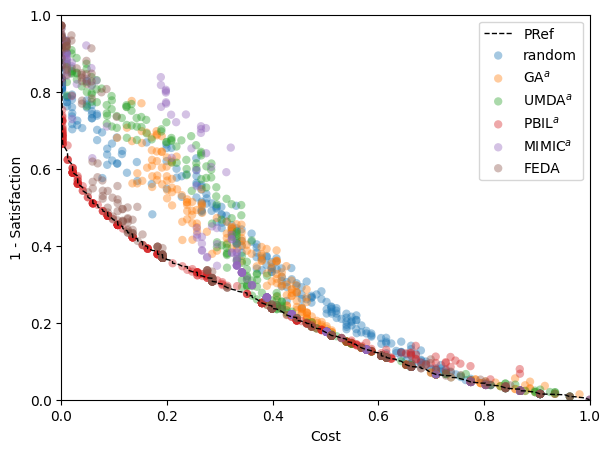

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.8605,0.0099,0.0557,0.6030,323.6237,76.4000
1,geneticNDS,0.8269,0.0224,0.0514,0.6561,956.5129,57.7667
2,UMDA,0.8584,0.0198,0.0505,0.5627,190.2232,69.6333
3,PBIL,0.9421,0.0465,0.0030,0.6031,610.3646,103.4667
4,MIMIC,0.8480,0.0247,0.0305,0.6176,1828.6836,159.0000
5,feda,0.9320,0.0381,0.0072,0.5564,1227.8951,98.3000


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
c3


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() go

Pareto Reference has 123 points
Maximum UNFR possible is 10/123=0.0813


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases lat

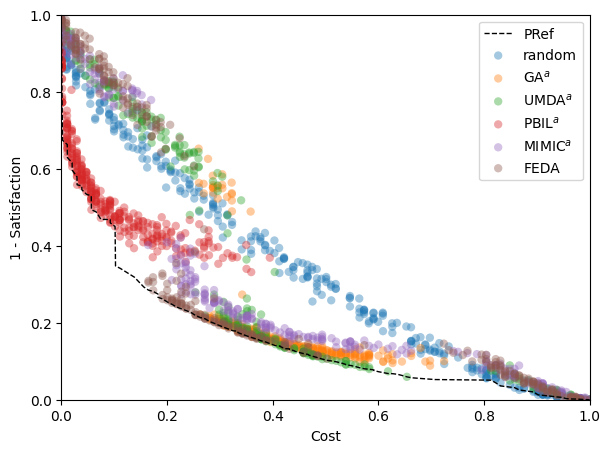

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.8238,0.0030,0.1069,0.6084,380.7176,88.1333
1,geneticNDS,0.7755,0.0003,0.0341,0.8092,498.0642,29.4333
2,UMDA,0.8779,0.0046,0.0614,0.5699,203.2730,65.7333
3,PBIL,0.7414,0.0043,0.0391,0.6520,457.6903,36.9000
4,MIMIC,0.8841,0.0016,0.0472,0.6052,1530.2491,50.1333
5,feda,0.9061,0.0049,0.0411,0.6381,1056.0230,57.4333


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
c4


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPy

Pareto Reference has 122 points
Maximum UNFR possible is 10/122=0.0820


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases lat

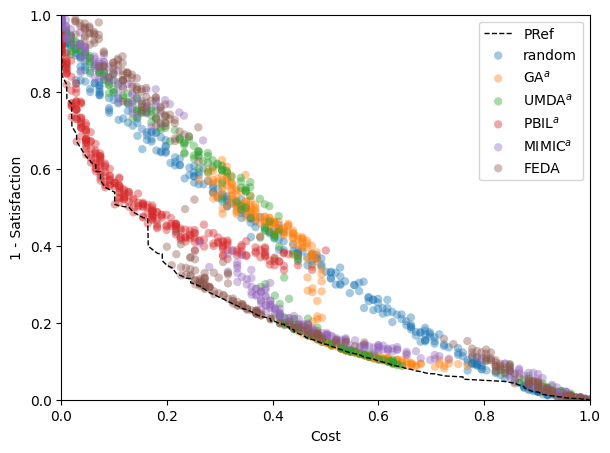

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.7874,0.0033,0.0982,0.5955,387.6061,91.2000
1,geneticNDS,0.7201,0.0000,0.0990,0.7518,563.9989,28.8000
2,UMDA,0.8204,0.0016,0.0752,0.5832,205.7963,61.0000
3,PBIL,0.7336,0.0046,0.0408,0.6020,577.1331,48.4333
4,MIMIC,0.8165,0.0036,0.0436,0.6332,1641.2006,56.3000
5,feda,0.8497,0.0052,0.0478,0.6148,1135.1211,59.4667


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
d1


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


Pareto Reference has 292 points
Maximum UNFR possible is 10/292=0.0342


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases lat

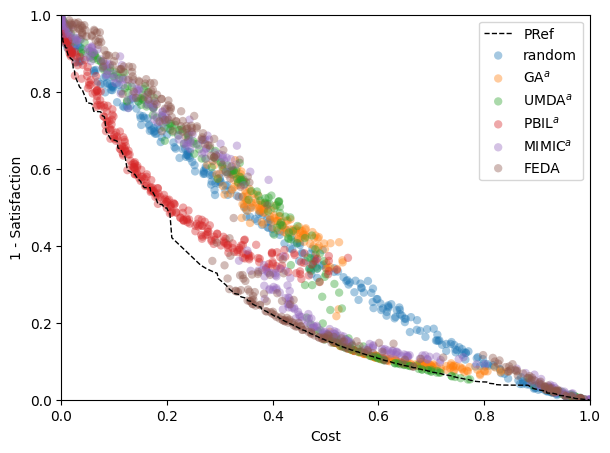

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.7715,0.0010,0.0843,0.5882,472.6963,126.2000
1,geneticNDS,0.7018,0.0039,0.0788,0.7466,1031.2082,64.1333
2,UMDA,0.7945,0.0037,0.0718,0.5627,340.7476,123.7667
3,PBIL,0.7197,0.0022,0.0388,0.5822,852.1981,71.1667
4,MIMIC,0.8026,0.0007,0.0545,0.5920,2035.8020,77.2333
5,feda,0.8098,0.0040,0.0514,0.5935,1980.0433,141.5000


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
d2


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPy

Pareto Reference has 294 points
Maximum UNFR possible is 10/294=0.0340


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases lat

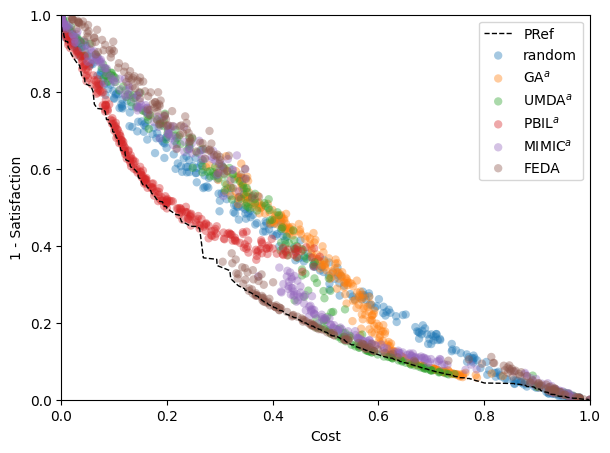

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.7793,0.0014,0.0689,0.6100,507.7946,121.2000
1,geneticNDS,0.6911,0.0000,0.0875,0.7227,1304.4686,79.4333
2,UMDA,0.8006,0.0046,0.0558,0.5709,376.9861,147.8667
3,PBIL,0.6934,0.0015,0.0263,0.5751,1043.5370,79.5667
4,MIMIC,0.7946,0.0005,0.0464,0.5667,2023.8627,81.8667
5,feda,0.8080,0.0029,0.0460,0.5963,3003.7764,200.3000


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
d3


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPy

Pareto Reference has 278 points
Maximum UNFR possible is 10/278=0.0360


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases lat

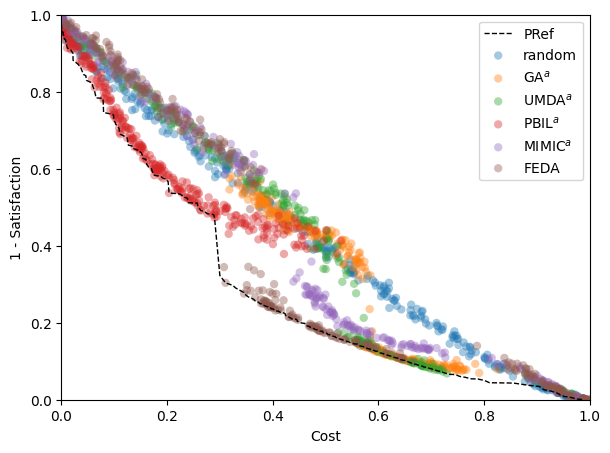

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.7394,0.0013,0.0839,0.5829,498.7871,139.4333
1,geneticNDS,0.6641,0.0016,0.0847,0.7588,1058.3602,63.0000
2,UMDA,0.7632,0.0014,0.0692,0.5703,312.3883,124.0667
3,PBIL,0.6441,0.0029,0.0327,0.5626,1091.6756,70.9667
4,MIMIC,0.7568,0.0002,0.0596,0.6119,3150.8023,74.5667
5,feda,0.7980,0.0024,0.0431,0.6004,2252.2656,166.1000


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

---------------------------------------------------------------
d4


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(new_row, ignore_index=True)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


Pareto Reference has 329 points
Maximum UNFR possible is 10/329=0.0304


/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases lat

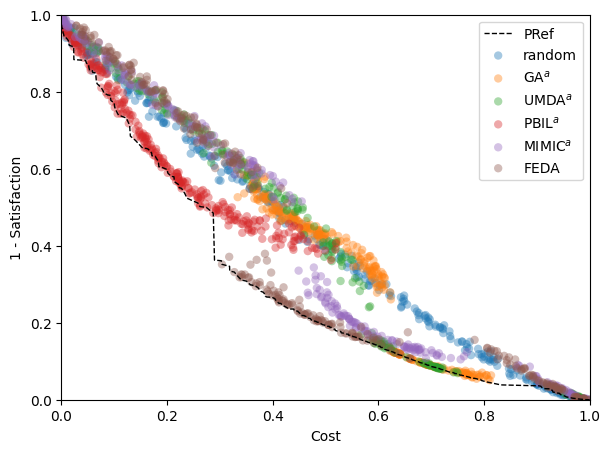

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,random,0.7315,0.0011,0.0767,0.6190,512.5538,153.2667
1,geneticNDS,0.6536,0.0029,0.0950,0.7388,1316.1915,81.6000
2,UMDA,0.7503,0.0013,0.0657,0.5695,367.9728,148.0333
3,PBIL,0.6451,0.0023,0.0322,0.5723,1244.9466,80.3000
4,MIMIC,0.7500,0.0003,0.0549,0.5833,3278.6407,79.6333
5,feda,0.7791,0.0016,0.0430,0.6063,2962.4292,192.3667


---------------------------------------------------------------
Wins Counts:
{'random': 0, 'geneticNDS': 0, 'UMDA': 0, 'PBIL': 5, 'MIMIC': 2, 'feda': 7}
Wins in datasets:
{'random': [], 'geneticNDS': [], 'UMDA': [], 'PBIL': ['p1', 'a1', 'a2', 'c1', 'c2'], 'MIMIC': ['p2', 'a4'], 'feda': ['a3', 'c3', 'c4', 'd1', 'd2', 'd3', 'd4']}
Wins Counts UNFR:
{'random': 1, 'geneticNDS': 2, 'UMDA': 1, 'PBIL': 5, 'MIMIC': 0, 'feda': 5}
Wins Counts GD+:
{'random': 0, 'geneticNDS': 1, 'UMDA': 0, 'PBIL': 13, 'MIMIC': 0, 'feda': 0}
Wins Counts Spread:
{'random': 1, 'geneticNDS': 0, 'UMDA': 5, 'PBIL': 4, 'MIMIC': 3, 'feda': 1}


/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/194346061.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  latex_df = latex_df.append(summary_df)


In [40]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


#display(best_for_grasp_df)
files_all_algorithms=[]

if use_best_config_in_all_datasets:

    files_all_algorithms =[ #call with best_for_... in the same order than the global algorithms array ['random','geneticNDS', 'UMDA', 'PBIL','MIMIC'] 
        get_files_list_with_best_configuration(best_for_random_df,datasets_names),
        get_files_list_with_best_configuration(best_for_geneticnds_df,datasets_names),
        get_files_list_with_best_configuration(best_for_umda_df,datasets_names),
        get_files_list_with_best_configuration(best_for_pbil_df,datasets_names),
        get_files_list_with_best_configuration(best_for_mimic_df,datasets_names),
    ]
    files_all_algorithms = files_all_algorithms + [get_files_list_with_best_configuration(best_for_feda_df,datasets_names)]

else: #use best config for each dataset in each algorithm
    for alg in algorithms:
        files_all_algorithms = files_all_algorithms + [get_files_list_with_best_configuration_per_dataset(alg_name=alg)]




wins_counts = {}
wins_counts_unfr = {}
wins_counts_gd = {}
wins_counts_spread = {}
wins_datasets = {}
for alg in algorithms:
    wins_counts[alg] = 0
    wins_datasets[alg] = []
    wins_counts_unfr[alg] = 0
    wins_counts_gd[alg] = 0
    wins_counts_spread[alg] = 0
 

# print 30 (or the number of execution) paretos of each dataset

latex_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])

#store results for statistical tests
friedman_HV_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] # almacenar HV: algorithmos en filas, datasets en columnas
friedman_unfr_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] 
friedman_gdplus_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] 
friedman_spread_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] 


for i in range(0,len(datasets_names)):
    fig = plt.figure(figsize=(15,5)) #20,5 when plotting also ax2 with table
    #ax =fig.add_axes([0,0,1,1])
    ax = fig.add_subplot(121)
    ax.set_xlabel('Cost')
    ax.set_ylabel('1 - Satisfaction')
    print(datasets_names[i])
   # ax.set_title(datasets_names[i])
    plt.xlim([0,1])
    plt.ylim([0,1])

    
    
    summary_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])
    
    for j in range(0,len(algorithms)):    
        try:
            file = files_all_algorithms[j][i] #they are ordered by dataset list initiated in first cell
            with open(file, 'r') as f:
                dictio = json.load(f)
            paretos_list = dictio['paretos']
            dataset = dictio['parameters']['dataset']
            metrics = dictio['metrics']
            pareto_reference = dictio['Reference_Pareto'] # any algorithm j has/should have the same PR for the same dataset. we use the last (same) after this loop
            
            (hv, unfr, gdplus, spread, time, nds) = (metrics['HV'], metrics['unfr'], metrics['gdplus'],metrics['spread'], metrics['time'], metrics['NDS_size'])
            dec=6
            new_row = {'Method': algorithms[j], 'HV':np.mean(hv).round(decimals=dec), 'UNFR':np.mean(unfr).round(decimals=dec), 'gd+':np.mean(gdplus).round(decimals=4),
             'spread':np.mean(spread).round(decimals=dec), 'time(s)':np.mean(time).round(decimals=dec), '|NDS|':np.mean(nds).round(decimals=dec)}
            friedman_HV_input[j][i] = new_row['HV']
            friedman_unfr_input[j][i] = new_row['UNFR']
            friedman_gdplus_input[j][i] = new_row['gd+']
            friedman_spread_input[j][i] = new_row['spread']
            

            for pareto in paretos_list: 
            #for p in range(10):
                #pareto = paretos_list[p]
                x = [item[0] for item in pareto]
                y = [1-item[1] for item in pareto] #revert satisfaction. 0,0 is best point
                plt.scatter(x, y, color='C'+str(j), alpha=0.4, edgecolors='none', label=algorithms[j], marker='o') # commonly 10 points (subset size in soluction subset selection)
                    
            
            summary_df = summary_df.append(new_row, ignore_index=True)
        except(FileNotFoundError, IOError):
            print(file, f"tried to be used due to {algorithms[j]} best configuration in this dataset, but file is not available yet")
        
    
    # update wins counts in HV
    idx = summary_df['HV'].idxmax()
    winner = summary_df.loc[idx]['Method']
    wins_counts[winner] = wins_counts[winner] + 1
    wins_datasets[winner].extend([datasets_names[i]])

    # update wins counts in UNFR
    idx_unfr = summary_df['UNFR'].idxmax()
    winner_unfr = summary_df.loc[idx_unfr]['Method']
    wins_counts_unfr[winner_unfr] = wins_counts_unfr[winner_unfr] + 1
    

    # update wins counts in gd+
    idx_gd = summary_df['gd+'].idxmin()
    winner_gd = summary_df.loc[idx_gd]['Method']
    wins_counts_gd[winner_gd] = wins_counts_gd[winner_gd] + 1


    # update wins counts in spread
    idx_spread = summary_df['spread'].idxmin()
    winner_spread = summary_df.loc[idx_spread]['Method']
    wins_counts_spread[winner_spread] = wins_counts_spread[winner_spread] + 1

    # print pareto reference
    print(f"Pareto Reference has {len(pareto_reference)} points")
    max_unfr = len(pareto) / len(pareto_reference)
    print(f"Maximum UNFR possible is {len(pareto)}/{len(pareto_reference)}={max_unfr:.4f}")
    x = [item[0] for item in pareto_reference]
    y = [1-item[1] for item in pareto_reference] #revert satisfaction. 0,0 is best point
    
    tuples = list(zip(x,y))
    tuples.sort()
    x = list(zip(*tuples))[0]
    y = list(zip(*tuples))[1]
    
    #plt.scatter(x, y, color='black', alpha=0.3, edgecolors='none', label='ParetoRef', marker='_') 
    plt.plot(x,y, linestyle="--", linewidth=1, color='black')


    handles, labels = plt.gca().get_legend_handles_labels() #remove repeated labels, since each label=j is repeated for all paretos of the 30 executions
    by_label = dict(zip(labels, handles))
    values = list(by_label.values())
    values = [Line2D([0], [0], color='black', linestyle='--',linewidth=1, label='PRef')] + values
    legend_keys=[r"GA$^a$" if s =="geneticNDS" else s for s in by_label.keys()]
    legend_keys=[r"UMDA$^a$" if s =="UMDA" else s for s in legend_keys]
    legend_keys=[r"PBIL$^a$" if s =="PBIL" else s for s in legend_keys]
    legend_keys=[r"MIMIC$^a$" if s =="MIMIC" else s for s in legend_keys]
    legend_keys=[r"FEDA" if s =="feda" else s for s in legend_keys]
    legend_keys= ["PRef"] + legend_keys

    plt.legend(values,legend_keys )        
    #plt.legend(by_label.values(), ["GA", "UMDA", "PBIL", "FEDA","ParetoRef"])        
    


    #plt.savefig("images/scatter_"+datasets_names[i]+".svg")
    plt.show()
    pd.set_option('display.float_format', '{:.4f}'.format)
    display(summary_df) # print in copy-paste format
    latex_df = latex_df.append(summary_df)
    print("---------------------------------------------------------------")
    

latex_df = latex_df.drop(columns=['time(s)'])
print("Wins Counts:") 
print(wins_counts)
print("Wins in datasets:")
print(wins_datasets)

print("Wins Counts UNFR:") 
print(wins_counts_unfr)
print("Wins Counts GD+:") 
print(wins_counts_gd)
print("Wins Counts Spread:") 
print(wins_counts_spread)

#print(friedman_HV_input)
             






In [25]:
pd.options.display.float_format = '{:.3f}'.format

edited_df = pd.DataFrame(latex_df)
edited_df[['|NDS|']] =  edited_df['|NDS|'].map("{:.1f}".format)


#display(edited_df)
#print(edited_df.to_latex(index=False))

ValueError: Columns must be same length as key

/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2230712883.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/HV-algorithms.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2230712883.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/HV-algorithms.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2230712883.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/HV-algorithms.svg")
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPytho

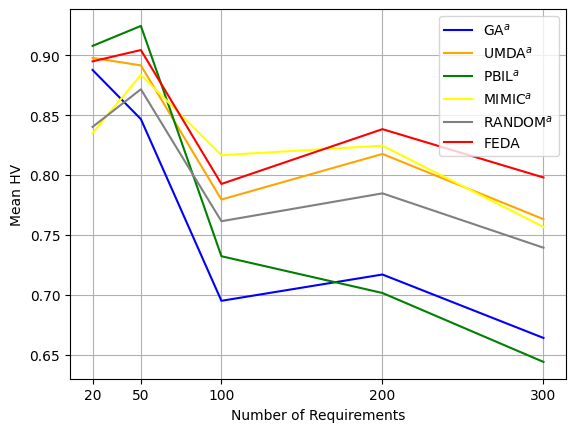

/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2230712883.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/HV-difference.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2230712883.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/HV-difference.svg")
/var/folders/j1/hvmr358s6g58jzlqvk5sykj80000gp/T/ipykernel_11079/2230712883.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("images/HV-difference.svg")
/Users/Pablo/Dropbox/INVESTIGACION/PROGRAMACION_PYTHON/MONRP/venvMAC/lib/python3.11/site-packages/IPytho

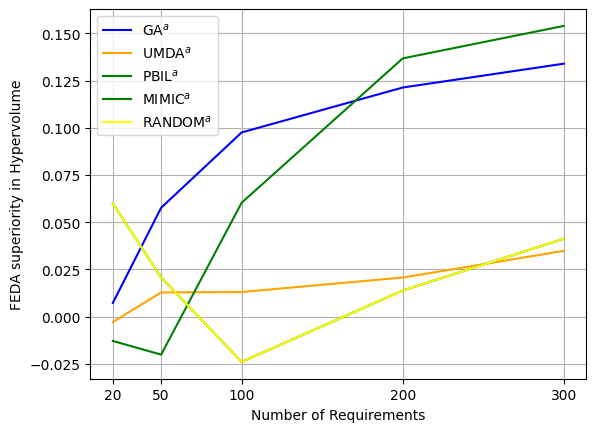

In [26]:
#plot HV for each algorithm, across datasets ordered by #pbi
# ['p1','a1','a2','c1','c2','p2','a3','a4','c3','c4','d3','d4','d6','d7']


ordered_by_pbis = [0,2,3,6,7,1,4,5,8,9,10,11,12,13] #index of datasets ordered by number of pbis

num_pbis = [20, 50, 50, 50, 50, 100, 200, 200, 200, 200, 200,200, 300, 300]


feda_values = latex_df[latex_df.Method=='feda'].HV.values[ordered_by_pbis] # si falla es porque no está un experimento con el mejor valor acabado
umda_values = latex_df[latex_df.Method=='UMDA'].HV.values[ordered_by_pbis]
pbil_values = latex_df[latex_df.Method=='PBIL'].HV.values[ordered_by_pbis]
mimic_values = latex_df[latex_df.Method=='MIMIC'].HV.values[ordered_by_pbis]
ga_values = latex_df[latex_df.Method=='geneticNDS'].HV.values[ordered_by_pbis]
random_values = latex_df[latex_df.Method=='random'].HV.values[ordered_by_pbis]

#get mean hv by the datasets with same number of pbis
feda_five_values = [feda_values[0]] + [np.mean(feda_values[1:4])]+ [feda_values[5]] + [np.mean(feda_values[6:11])]+ [np.mean(feda_values[12:13])]
umda_five_values = [umda_values[0]] + [np.mean(umda_values[1:4])]+ [umda_values[5]] + [np.mean(umda_values[6:11])]+ [np.mean(umda_values[12:13])]
pbil_five_values = [pbil_values[0]] + [np.mean(pbil_values[1:4])]+ [pbil_values[5]] + [np.mean(pbil_values[6:11])]+ [np.mean(pbil_values[12:13])]
mimic_five_values = [mimic_values[0]] + [np.mean(mimic_values[1:4])]+ [mimic_values[5]] + [np.mean(mimic_values[6:11])]+ [np.mean(mimic_values[12:13])]
ga_five_values = [ga_values[0]] + [np.mean(ga_values[1:4])]+ [ga_values[5]] + [np.mean(ga_values[6:11])]+ [np.mean(ga_values[12:13])]
random_five_values = [random_values[0]] + [np.mean(random_values[1:4])]+ [random_values[5]] + [np.mean(random_values[6:11])]+ [np.mean(random_values[12:13])]


#plot mean value of hv given datasets with the same number of pbis
x_axis=[20, 50, 100, 200, 300]
plt.plot(x_axis, ga_five_values, color='blue', label=r'GA$^a$') 
plt.plot(x_axis, umda_five_values, color='orange', label=r'UMDA$^a$') 
plt.plot(x_axis, pbil_five_values, color='green', label=r'PBIL$^a$') 
plt.plot(x_axis, mimic_five_values, color='yellow', label=r'MIMIC$^a$') 
plt.plot(x_axis, random_five_values, color='grey', label=r'RANDOM$^a$') 
plt.plot(x_axis, feda_five_values, color='red', label='FEDA') 
plt.xlabel("Number of Requirements")
plt.ylabel("Mean HV")
plt.xticks(x_axis)
plt.grid(b=None)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())    
plt.savefig("images/HV-algorithms.svg")
plt.show()


# see if the difference in HV increases with number of pbis

diff_ga = np.array(feda_five_values) - np.array(ga_five_values)
diff_umda = np.array(feda_five_values) - np.array(umda_five_values)
diff_pbil = np.array(feda_five_values) - np.array(pbil_five_values)
diff_mimic = np.array(feda_five_values) - np.array(mimic_five_values)
diff_random = np.array(feda_five_values) - np.array(random_five_values)

plt.plot(x_axis, diff_ga, color='blue', label=r'GA$^a$') 
plt.plot(x_axis, diff_umda, color='orange', label=r'UMDA$^a$') 
plt.plot(x_axis, diff_pbil, color='green', label=r'PBIL$^a$') 
plt.plot(x_axis, diff_mimic, color='green', label=r'MIMIC$^a$') 
plt.plot(x_axis, diff_mimic, color='yellow', label=r'RANDOM$^a$') 
plt.xlabel("Number of Requirements")
plt.ylabel("FEDA superiority in Hypervolume")
plt.xticks(x_axis)
plt.grid(b=None)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())    
plt.savefig("images/HV-difference.svg")
plt.show()






    

Given the results, we see that PBIL behaves really well in datasets wich not a large number of requirements (aX and cX datasets). In the case dX datasets, with hundreds of requirements, FEDA obtains greater Hypervolumes than PBIL and the rest of algorithms. In some cases, FEDA obtains a very similar HV value than PBIL or UMDA; in such cases, in order to be sure that FEDA performs better we can take into account the UNFR value, which is pareto compliant, and when FEDA's HV is just slightly better, UNFR is clearly better than the other algorithm. \\

A withdraw FEDA presents is that its execution time is much worse than the other algorithms. This is mostly due to the large number of Non Dominated Solutions it finds. \\

Respect to gd+, FEDA is usually the second algorithm with best (lowest) mean general distance to the Pareto Reference, while PBIL commonly finds the closer solutions to the PR, although its HV covered is lower, as said, when the project presents hundreds of requirements.

#### 4.4 Statistical tests
Friedman: non-parametric group test, dependent samples (same datasets used in all methods)
post hoc: nemenyi pairwise test 


##### 4.4.1 All datasets together

In [100]:
from scipy import stats
import scikit_posthocs as sp
import numpy as np
#https://www.statology.org/nemenyi-test-python/

def friedman(*algorithms_x_datasets_values, metric_name): #algorithms in rows, datasets in columns
    print(metric_name)
    pvalue=stats.friedmanchisquare(*algorithms_x_datasets_values).pvalue

    if(pvalue>0.05):
        print("Friedman test not sifnificant!")
    else:
        # convert the list of lists to a numpy array
        algorithms_x_datasets_values = np.array(algorithms_x_datasets_values)
       
        #result = sp.posthoc_mannwhitney(algorithms_x_datasets_values, p_adjust = 'fdr_bh') #alternative='less'
        #result = sp.posthoc_nemenyi_friedman(algorithms_x_datasets_values.T)
        #paired Pairwise comparisons with Wilcoxon signed-rank test.
        result = sp.posthoc_wilcoxon(algorithms_x_datasets_values,p_adjust='fdr_bh')
        
        
        # Set the row and column names of the DataFrame using the algorithm names
        result.index = algorithms
        result.columns = algorithms
        # Highlight cells with values less than 0.05
        highlight = lambda x: 'background-color: green' if x < 0.05 else ''
        styled_result = result.style.applymap(highlight)
        # display the result DataFrame
        display(styled_result)




In [101]:

friedman(*friedman_HV_input, metric_name='HV')
print('random',np.mean(friedman_HV_input[0]))
print('geneticNDS',np.mean(friedman_HV_input[1]))
print('UMDA',np.mean(friedman_HV_input[2]))
print('PBIL',np.mean(friedman_HV_input[3]))
print('MIMIC',np.mean(friedman_HV_input[4]))
print('feda',np.mean(friedman_HV_input[5]))

friedman(*friedman_unfr_input,metric_name='UNFR')
friedman(*friedman_gdplus_input,metric_name='GD+')
friedman(*friedman_spread_input,metric_name='Spread')

HV


,random,geneticNDS,UMDA,PBIL,MIMIC,feda
random,1.000000,0.002289,0.001099,0.137188,0.002289,0.000610
geneticNDS,0.002289,1.000000,0.000610,0.232021,0.002289,0.000610
UMDA,0.001099,0.000610,1.000000,0.033458,0.855225,0.000916
PBIL,0.137188,0.232021,0.033458,1.000000,0.036926,0.024902
MIMIC,0.002289,0.002289,0.855225,0.036926,1.000000,0.006714
feda,0.000610,0.000610,0.000916,0.024902,0.006714,1.000000


random 80.3652
geneticNDS 75.31306428571429
UMDA 82.94701428571429
PBIL 77.47402857142858
MIMIC 82.67511428571427
feda 85.06499285714287
UNFR
Friedman test not sifnificant!
GD+


,random,geneticNDS,UMDA,PBIL,MIMIC,feda
random,1.000000,0.583008,0.000305,0.000305,0.000458,0.000305
geneticNDS,0.583008,1.000000,0.013428,0.000610,0.011652,0.000916
UMDA,0.000305,0.013428,1.000000,0.000305,0.019156,0.000458
PBIL,0.000305,0.000610,0.000305,1.000000,0.000305,0.000305
MIMIC,0.000458,0.011652,0.019156,0.000305,1.000000,0.052970
feda,0.000305,0.000916,0.000458,0.000305,0.052970,1.000000


Spread


,random,geneticNDS,UMDA,PBIL,MIMIC,feda
random,1.000000,0.002616,0.001831,0.208740,0.669800,0.496216
geneticNDS,0.002616,1.000000,0.001831,0.001831,0.002289,0.002616
UMDA,0.001831,0.001831,1.000000,0.242157,0.031128,0.002563
PBIL,0.208740,0.001831,0.242157,1.000000,0.278320,0.150960
MIMIC,0.669800,0.002289,0.031128,0.278320,1.000000,0.208740
feda,0.496216,0.002616,0.002563,0.150960,0.208740,1.000000


##### 4.4.1 Per dataset type

In [103]:

from scipy.stats import wilcoxon


#detectar dónde empieza el primer índice cX. Asume que están ordenados 
for i, dataset_name in enumerate(datasets_names):
    if dataset_name.startswith('c'):
        complex_datasets_start =i
        break

complex_datasets_start=8 #c3
friedman_HV_input_simple = []
friedman_HV_input_complex = []

for sublist in friedman_HV_input:
    friedman_HV_input_simple.append(sublist[:complex_datasets_start])
    friedman_HV_input_complex.append(sublist[complex_datasets_start:])




friedman(*friedman_HV_input_simple, metric_name='HV simple datasets')
print(friedman_HV_input_complex)
friedman(*friedman_HV_input_complex, metric_name='HV complex datasets')


print("PBIL:", friedman_HV_input_complex[3])
print("feda:",friedman_HV_input_complex[5])
print(wilcoxon(friedman_HV_input_complex[3],friedman_HV_input_complex[5]))

print('random',np.mean(friedman_HV_input_complex[0]))
print('geneticNDS',np.mean(friedman_HV_input_complex[1]))
print('UMDA',np.mean(friedman_HV_input_complex[2]))
print('PBIL',np.mean(friedman_HV_input_complex[3]))
print('MIMIC',np.mean(friedman_HV_input_complex[4]))
print('feda',np.mean(friedman_HV_input_complex[5]))



HV simple datasets


,random,geneticNDS,UMDA,PBIL,MIMIC,feda
random,1.000000,0.146484,0.070312,0.945312,0.146484,0.039062
geneticNDS,0.146484,1.000000,0.039062,0.164062,0.146484,0.039062
UMDA,0.070312,0.039062,1.000000,0.904018,0.904018,0.058594
PBIL,0.945312,0.164062,0.904018,1.000000,0.904018,0.904018
MIMIC,0.146484,0.146484,0.904018,0.904018,1.000000,0.164062
feda,0.039062,0.039062,0.058594,0.904018,0.164062,1.000000


[[82.38210000000001, 78.743, 77.1468, 77.93379999999999, 73.942, 73.1476], [77.54910000000001, 72.0109, 70.1822, 69.1129, 66.4143, 65.36110000000001], [87.78970000000001, 82.03540000000001, 79.4469, 80.0592, 76.3174, 75.031], [74.14410000000001, 73.36110000000001, 71.974, 69.33550000000001, 64.4145, 64.51259999999999], [88.4135, 81.65050000000001, 80.26440000000001, 79.4584, 75.67960000000001, 74.99749999999999], [90.6083, 84.9659, 80.9812, 80.7966, 79.80120000000001, 77.91369999999999]]
HV complex datasets


,random,geneticNDS,UMDA,PBIL,MIMIC,feda
random,1.000000,0.036058,0.036058,0.036058,0.036058,0.036058
geneticNDS,0.036058,1.000000,0.036058,0.736607,0.036058,0.036058
UMDA,0.036058,0.036058,1.000000,0.036058,1.000000,0.036058
PBIL,0.036058,0.736607,0.036058,1.000000,0.036058,0.036058
MIMIC,0.036058,0.036058,1.000000,0.036058,1.000000,0.036058
feda,0.036058,0.036058,0.036058,0.036058,0.036058,1.000000


PBIL: [74.14410000000001, 73.36110000000001, 71.974, 69.33550000000001, 64.4145, 64.51259999999999]
feda: [90.6083, 84.9659, 80.9812, 80.7966, 79.80120000000001, 77.91369999999999]
WilcoxonResult(statistic=0.0, pvalue=0.03125)
random 77.21588333333334
geneticNDS 70.10508333333334
UMDA 80.11326666666668
PBIL 69.62363333333333
MIMIC 80.07731666666668
feda 82.51115


In [104]:

friedman_p, pvalue = friedmanchisquare(*friedman_HV_input_complex)
print(pvalue)


#algorithms_x_datasets_values = np.array(algorithms_x_datasets_values)
       
#result = sp.posthoc_mannwhitney(algorithms_x_datasets_values, p_adjust = 'holm') #alternative='less'
result = sp.posthoc_nemenyi_friedman(np.array(friedman_HV_input_complex).T)
print(result)
result = sp.posthoc_wilcoxon(friedman_HV_input_complex)
print(result)
result = sp.posthoc_wilcoxon(friedman_HV_input_complex,p_adjust='fdr_bh') #redudes false discovery rate
print(result)



3.065960949091181e-05
       0      1      2      3      4      5
0 1.0000 0.7069 0.6178 0.7069 0.7960 0.0612
1 0.7069 1.0000 0.0395 0.9000 0.0915 0.0010
2 0.6178 0.0395 1.0000 0.0395 0.9000 0.7960
3 0.7069 0.9000 0.0395 1.0000 0.0915 0.0010
4 0.7960 0.0915 0.9000 0.0915 1.0000 0.6178
5 0.0612 0.0010 0.7960 0.0010 0.6178 1.0000
       1      2      3      4      5      6
1 1.0000 0.0312 0.0312 0.0312 0.0312 0.0312
2 0.0312 1.0000 0.0312 0.6875 0.0312 0.0312
3 0.0312 0.0312 1.0000 0.0312 1.0000 0.0312
4 0.0312 0.6875 0.0312 1.0000 0.0312 0.0312
5 0.0312 0.0312 1.0000 0.0312 1.0000 0.0312
6 0.0312 0.0312 0.0312 0.0312 0.0312 1.0000
       1      2      3      4      5      6
1 1.0000 0.0361 0.0361 0.0361 0.0361 0.0361
2 0.0361 1.0000 0.0361 0.7366 0.0361 0.0361
3 0.0361 0.0361 1.0000 0.0361 1.0000 0.0361
4 0.0361 0.7366 0.0361 1.0000 0.0361 0.0361
5 0.0361 0.0361 1.0000 0.0361 1.0000 0.0361
6 0.0361 0.0361 0.0361 0.0361 0.0361 1.0000


In [53]:
from scipy.stats import friedmanchisquare
import Orange




# Compute the critical differenc
ranks = np.argsort(np.mean(complex_data, axis=0))[::-1] + 1
cd = Orange.scoring.compute_CD(ranks, N=8, num_algorithms=6, alpha=0.05, type='nemenyi')
print("Critical difference: {:.4f}".format(cd))

# Plot the algorithm ranks
#ranks = np.argsort(np.mean(complex_data, axis=0))[::-1] + 1
#Orange.evaluation.graph_ranks(ranks, num_algorithms, cd=cd, width=6, textspace=1.5)

ModuleNotFoundError: No module named 'Orange'

#### 4.3 Execution times



../output/umda/umdaTrued35100False1000500ndselitism30.json tried to be used due to UMDA best configuration in this dataset, but file is not available yet


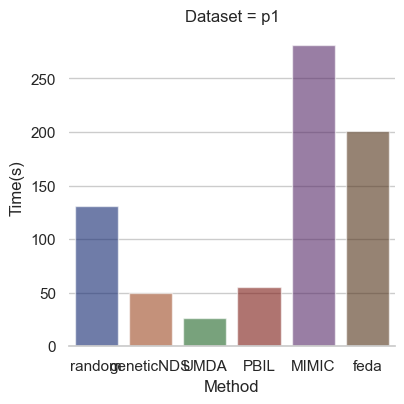

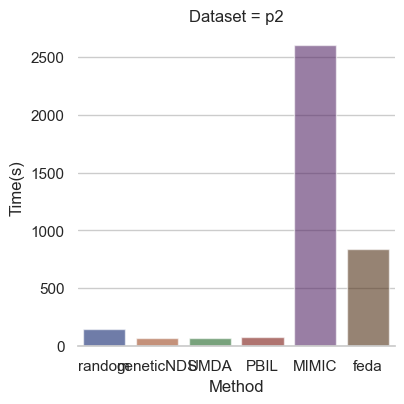

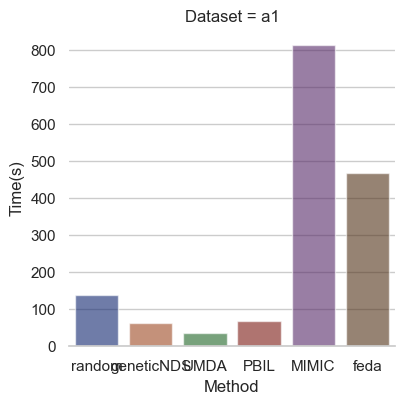

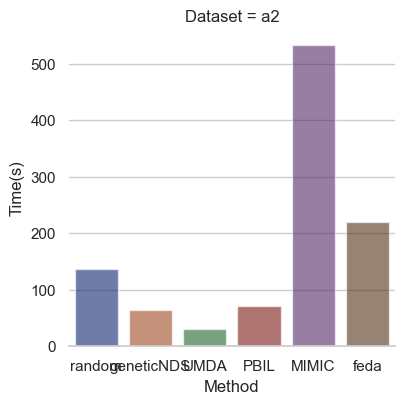

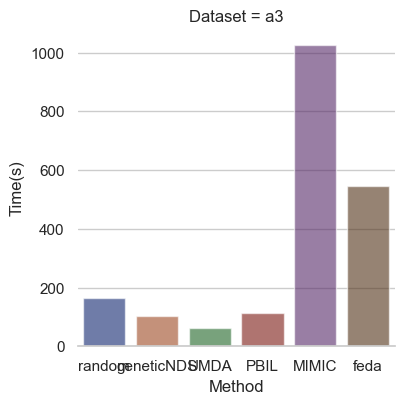

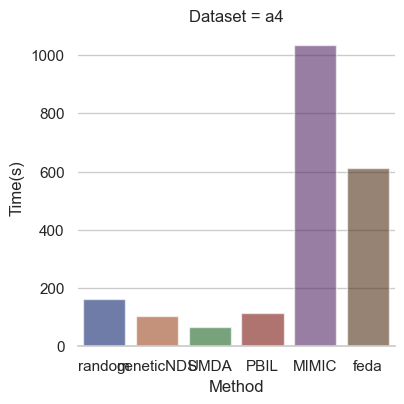

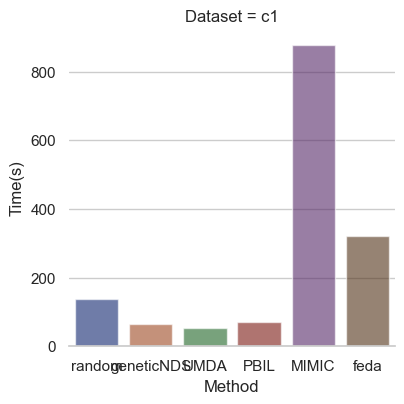

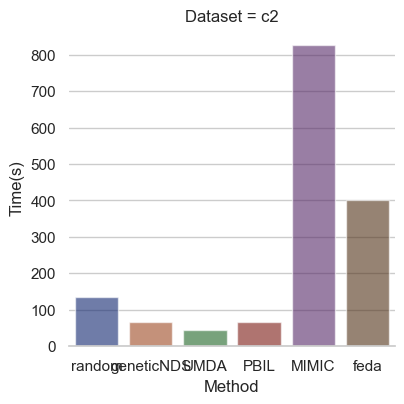

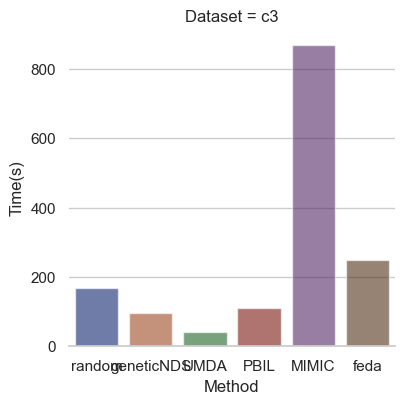

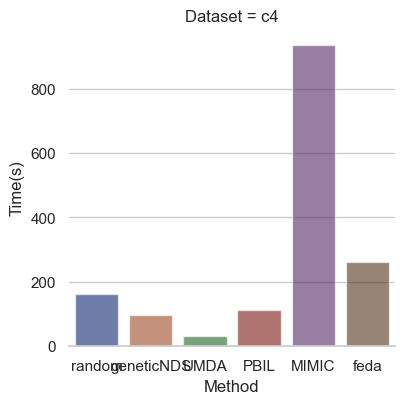

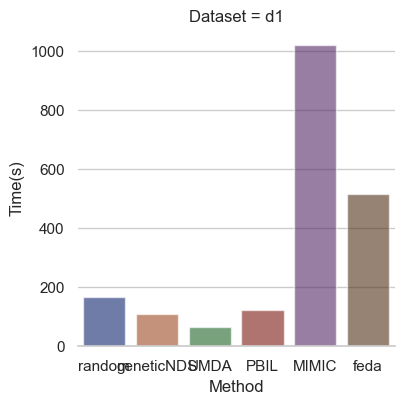

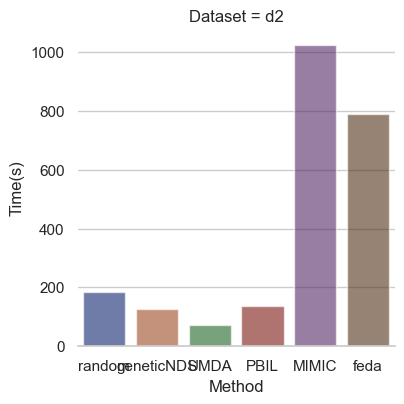

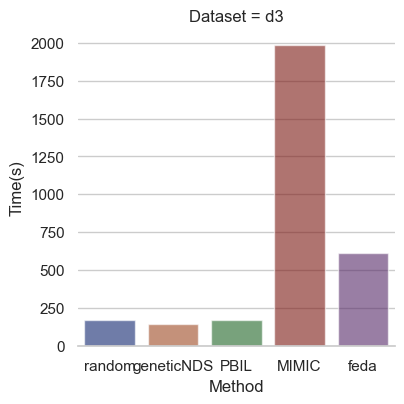

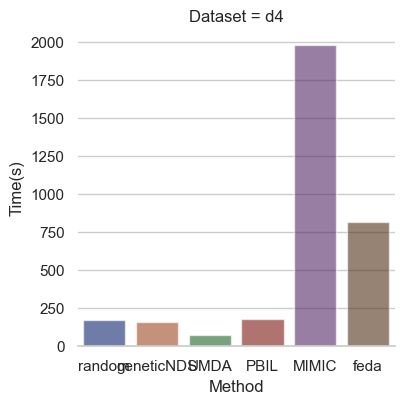

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

labels = np.unique(datasets_names)
x = np.arange(len(labels))
width = 0.1
for i in range(0,len(datasets_names)):
    
    times_df = pd.DataFrame(columns=["Dataset","Method","Time(s)"])
    
    for j in range(0,len(algorithms)):    
        algorithms_time = []
        try:
            file = files_all_algorithms[j][i] #they are ordered by dataset list
            with open(file, 'r') as f:
                dictio = json.load(f)
            paretos_list = dictio['paretos']
            dataset = dictio['parameters']['dataset']
            metrics = dictio['metrics']
            time = metrics['time']
            nds_update = metrics['nds_update_time']
            new_row = {'Dataset': dataset, 'Method': algorithms[j], 'Time(s)': np.mean(time)-np.mean(nds_update)}
            times_df = times_df.append(new_row, ignore_index=True)
            #algorithms_time.extend([np.mean(time)])
            

        except(FileNotFoundError, IOError):
            print(file, f"tried to be used due to {algorithms[j]} best configuration in this dataset, but file is not available yet")

    #display(times_df)
    g = sns.catplot(data=times_df, kind="bar",  col="Dataset", y="Time(s)", x="Method", ci="sd", palette="dark", alpha=.6, height=4)
  
    g.despine(left=True)
   

